# Simple Rule Based Programming

เวิร์กช็อปนี้เป็นการฝึกเขียนโค้ด Python โดยใช้เทคนิค rule based programming

### วัตถุประสงค์
1. ฝึกเขียนเงื่อนไขโดยใช้ np.where() ในเวิร์กช็อป DQIF (ในการใช้งานจริงจะใช้ FELib.iif() ซึ่งเป็นฟังก์ชั่นที่อยู่ในคลาสชื่อ FELib อยู่ใน deepquant.common.felib.py)
2. ฝึกเขียน rule ที่มีหลายเงื่อนไขโดยใช้โอเปอเรเตอร์ต่างๆ เช่น &, |
3. ฝึกเขียน rule ที่ใช้ฟังก์ชั่นด้าน time series เช่น min(llv), max(hhv), stdev (standard deviation)
4. ฝึกเขียน rule สำหรับ predict signal
5. ฝึกเขียน rule สำหรับตรวจจับรูปแบบ (pattern) ของสภาวะตลาด

### การนำไปใช้
การเขียนโค้ดด้วยเทคนิค rule based programming สามารถนำไปใช้ได้ในหลายกรณี เช่น
1. การ predict signal
2. การ filter signal
3. การตรวจจับรูปแบบสภาวะตลาด
4. การเตรียม dataset

### Prerequisite
1. เขียนโค้ด Python พอได้ระดับหนึ่ง สามารถฝึกได้จากเวิร์กช็อป 'Basic Python Coding' (https://deepquantspace.com/2022/11/27/basic-python/)
2. เขียนโค้ด Python สร้าง technical indicator พอได้ระดับหนึ่ง สามารถฝึกได้จากเวิร์กช็อป 'เขียน Python สร้าง indicator และ visualize chart' (https://deepquantspace.com/2022/12/12/create-and_visualize-indi-using-python/)

In [763]:
import os
import math
import pandas as pd
import numpy as np
import pandas_ta as pdta
import matplotlib.pyplot as plt
import mplfinance as mpf


def data_range(df_dataset, from_date='', to_date='', window=100):
    dt_col = 'DATETIME' if 'DATETIME' in df_dataset else 'datetime'
    
    if from_date == '' and to_date == '':
        df_dataset = df_dataset.iloc[df_dataset.shape[0]-window:df_dataset.shape[0], :].copy()
    else:
        if from_date is not None and from_date != '' and to_date is not None and to_date != '':
            from_date = '{}000000'.format(from_date.replace('-', ''))
            to_date = '{}235500'.format(to_date.replace('-', ''))

            df_dataset = df_dataset.loc[(df_dataset[dt_col].astype(str) >= from_date) \
                                            & (df_dataset[dt_col].astype(str) <= to_date)]
            df_dataset = df_dataset.reset_index(drop=True)

    return df_dataset

def build_ohlc_df(df_master):
    df = pd.DataFrame(df_master, copy=True)
    df['DATETIME'] = df_master['DATETIME']
    df['Open'] = df_master['OPEN']
    df['High'] = df_master['HIGH']
    df['Low'] = df_master['LOW']
    df['Close'] = df_master['CLOSE']
    return df


def plot_df(data, col, title, x_label, y_label, plot_label, data_x=None, data_y=None
            , chart_width=20, chart_height=8
            , fontsize_axis=14, fontsize_title=20, fontsize_legend=1
            , legend_position='upper right'):
    plt.figure(figsize=(chart_width, chart_height))
    if data is not None:
        x = np.arange(data.shape[0])
        y = data[col]
    else:
        x = data_x
        y = data_y
    plt.plot(x, y, label=plot_label)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.title(title, fontsize=20)
    plt.legend(loc='upper right', fontsize=1)
    plt.show()

def plot_ohlc(data, type='candle', style='charles', title='Signals'
             , ylabel='Prices', figratio=(20, 8)
             , addplot=None,):
    if addplot is None:
        mpf.plot(data, type=type, style=style, title=title
                 , ylabel=ylabel, figratio=figratio
                 , **{'warn_too_much_data':data.shape[0] + 1}
                 ,)
    else:
        mpf.plot(data, type=type, style=style, title=title
                 , ylabel=ylabel, figratio=figratio, addplot=addplot
                 , **{'warn_too_much_data':data.shape[0] + 1}
                 ,)
        
def plot_ohlc_sig(data_ohlc, data_sig, markersize=100
                  , buy_pos=0.999, sell_pos=1.001
                  , c_width=30, c_height=8):

    sig_open_buy = np.where(data_sig['SIGNAL'] == 1, 1, 0)
    sig_open_sell = np.where(data_sig['SIGNAL'] == 11, 11, 0)

    sig_buy_arrow_pos = np.where(sig_open_buy > 0, 1, np.nan) * buy_pos * data_ohlc['Low']
    sig_sell_arrow_pos = np.where(sig_open_sell > 0, 1, np.nan) * sell_pos * data_ohlc['High']

    arrows = []
    if 1 in sig_open_buy:
        arrows.append(mpf.make_addplot(sig_buy_arrow_pos, scatter=True, markersize=markersize, marker=r'$\Uparrow$', color='green'))
    if 11 in sig_open_sell:
        arrows.append(mpf.make_addplot(sig_sell_arrow_pos, scatter=True, markersize=markersize, marker=r'$\Downarrow$', color='red'))
    
    plot_ohlc(data_ohlc
                , type='candle' # type='line'
                , style='charles'
                , title='Signals'
                , ylabel='Prices'
                , figratio=(c_width, c_height)
                , addplot=arrows
                ,)

## FELib class

FELib เป็นโค้ด utility สำหรับช่วยทำ feature engineering โค้ดตัวเต็มอยู่ในแพ็กเกจ deepquant.common.felib.py ซึ่งมีฟังก์ชั่นช่วยทำ feature engineering หลายฟังก์ชั่น และสามารถ extend class เพื่อพัฒนาต่อยอดได้

In [764]:
class FELib:
    """
    Simple Feature Engineering Library
    """

    @staticmethod
    def iif(condition, resultTrue, resultFalse):
        return np.where(condition, resultTrue, resultFalse)

    @staticmethod
    def llv(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            series = series.fillna(0)
            result = series.rolling(period, min_periods=1).min()
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

    @staticmethod
    def hhv(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            # series = series.fillna(0)
            result = series.rolling(period, min_periods=1).max()
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

    @staticmethod
    def ma(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            series = series.fillna(0)
            result = series.rolling(period, min_periods=1).mean()
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

    @staticmethod
    def stdev(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            series = series.fillna(0)
            result = series.rolling(period, min_periods=1).std(skipna=True)
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result
    
    @staticmethod
    def count_col_cond(col, condition, period, shift=None):
        """Sample code
        col = df['stoch_d'] # df is pandas dataframe
        cond = f"(col >= 70) & (FELib.ref(col, -1) < 70) & (FELib.ref(col, -1) != 0)"
        df['stoch_d_cross_over_num'] = count_col_cond_v(col, cond, period=7, shift=5)
        """

        if shift is not None:
            if shift  <= 0:
                raise Exception("Argument 'shift' in count_col_cond() must greater than 0.")
            col = FELib.shift(col, shift)

        if period <= 1 or period >= col.shape[0]:
            raise Exception("period in count_series_cond() must be > 1 and < total rows")

        data_mask = (eval(condition))
        series = pd.Series(FELib.iif(data_mask == True, 1, np.NaN))
        total = series.rolling(period).count()

        return total

## Load price data file

ข้อมูลในเวิร์กช็อปนี้เป็นไฟล์ราคาทองคำไทม์เฟรม 5 นาที ตั้งแต่ปี 2021-01-1 ถึง 2022-11-30

In [765]:
source_price_path = '../datasets/FX'
price_file = 'XAUUSD_M5.csv'

# โหลดไฟล์ราคา
dataset = pd.read_csv(f'{source_price_path}/{price_file}')

# แสดงตารางข้อมูลราคา
dataset

DATETIME      OPEN      HIGH       LOW     CLOSE  VOLUME
0       20210103230000  1904.998  1910.898  1903.288  1908.850    1516
1       20210103230500  1908.878  1909.258  1907.618  1908.568    1009
2       20210103231000  1908.518  1909.405  1907.665  1908.805     671
3       20210103231500  1908.785  1909.678  1907.978  1909.358     398
4       20210103232000  1909.368  1910.588  1909.005  1909.048     424
...                ...       ...       ...       ...       ...     ...
135727  20221130003500  1750.158  1750.478  1749.868  1750.398     238
135728  20221130004000  1750.418  1750.638  1749.998  1750.208     190
135729  20221130004500  1750.218  1750.588  1750.168  1750.308     227
135730  20221130005000  1750.187  1750.498  1749.958  1750.298     341
135731  20221130005500  1750.298  1751.058  1750.227  1751.058     258

[135732 rows x 6 columns]

## Visualize candlestick chart

ให้ระบุช่วงของวันที่ที่สนใจในฟีลด์ data_start กับ date_end หรือระบุจำนวนแท่งสูงสุดที่ต้องการในฟีลด์ window_chart

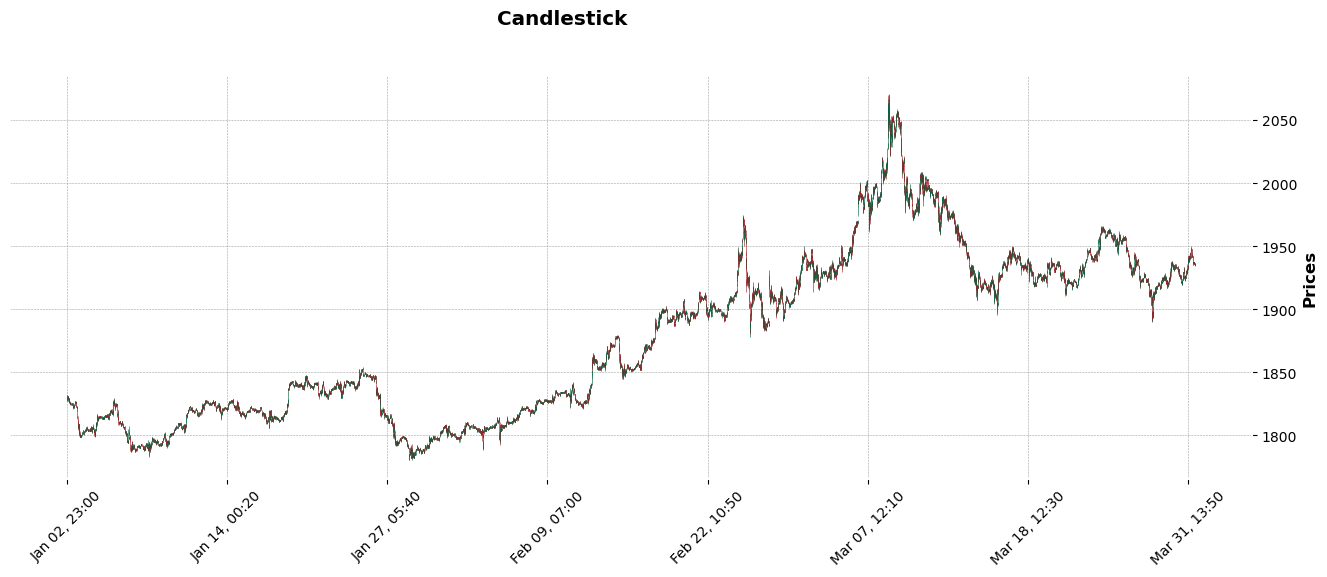

In [766]:
# Plot candlestick chart

# ระบุ date_start กับ date_end หรือระบุ window_chart อย่างใดอย่างหนึ่ง
date_start = '20220101' # example: 20210101 format is YYYYmmdd
date_end = '20220331' # example: 20210131 format is YYYYmmdd
window_chart = 2000 # จำนวนแท่งราคาล่าสุดที่ต้องการแสดงผล

chart_width = 30 # ระบุความกว้า่ง
chart_height = 10 # ระบุความสูง

#===============================================================================================

df_ohlc = pd.DataFrame()

df_ohlc['DATETIME'] = dataset['DATETIME']    
df_ohlc['Open'] = dataset['OPEN']
df_ohlc['High'] = dataset['HIGH']
df_ohlc['Low'] = dataset['LOW']
df_ohlc['Close'] = dataset['CLOSE']

# Get sub data
df_ohlc = data_range(df_ohlc, from_date=date_start, to_date=date_end, window=window_chart)

df_ohlc['DATETIME'] = pd.to_datetime(df_ohlc['DATETIME'], format='%Y%m%d%H%M%S')
df_ohlc.set_index('DATETIME', inplace=True)

plot_ohlc(df_ohlc
            , type='candle' # type='line'
            , style='charles'
            , title='Candlestick'
            , ylabel='Prices'
            , figratio=(chart_width, chart_height),)

## Construct technical indicators

In [767]:
# SMA
dataset['MA1'] = pdta.sma(dataset['CLOSE'], 50)

# WMA
dataset['MA2'] = pdta.wma(dataset['CLOSE'], 100)

# EMA
dataset['MA3'] = pdta.ema(dataset['CLOSE'], 300)

# RSI
dataset['RSI_S'] = pdta.rsi(dataset['CLOSE'], 14)
dataset['RSI_M'] = pdta.rsi(dataset['CLOSE'], 28)
dataset['RSI_L'] = pdta.ema( pdta.rsi(dataset['CLOSE'], 50), 20 )

# MACD
df_macd_s = pdta.macd(dataset['CLOSE'], 12, 26, 9)
dataset['MACD_S'] = df_macd_s.iloc[:, 0]
dataset['MACD_HIST_S'] = df_macd_s.iloc[:, 1]
dataset['MACD_SIGNAL_S'] = df_macd_s.iloc[:, 2]

# ATR
dataset['ATR'] = pdta.atr(dataset['HIGH']
                          , dataset['LOW']
                          , dataset['CLOSE']
                          , 20)

# NATR (Normalized Average True Range)
dataset['NATR'] = pdta.natr(dataset['HIGH']
                          , dataset['LOW']
                          , dataset['CLOSE']
                          , 20)
dataset['NATR'] = dataset['NATR'] * 100

# Slow Stochastics
df_slow_s = pdta.stoch(dataset['HIGH']
                       , dataset['LOW']
                       , dataset['CLOSE']
                       , 9, 3, 3, 'wma')
dataset['STOCHK_S'] = df_slow_s.iloc[:, 0]
dataset['STOCHD_S'] = df_slow_s.iloc[:, 1]

# Slow Stochastics
df_slow_m = pdta.stoch(dataset['HIGH']
                       , dataset['LOW']
                       , dataset['CLOSE']
                       , 90, 30, 30, 'wma')
dataset['STOCHK_M'] = df_slow_m.iloc[:, 0]
dataset['STOCHD_M'] = df_slow_m.iloc[:, 1]

dataset.fillna(0.0, inplace=True) # fill ค่า NaN ด้วยค่า 0.0

dataset

DATETIME      OPEN      HIGH       LOW     CLOSE  VOLUME  \
0       20210103230000  1904.998  1910.898  1903.288  1908.850    1516   
1       20210103230500  1908.878  1909.258  1907.618  1908.568    1009   
2       20210103231000  1908.518  1909.405  1907.665  1908.805     671   
3       20210103231500  1908.785  1909.678  1907.978  1909.358     398   
4       20210103232000  1909.368  1910.588  1909.005  1909.048     424   
...                ...       ...       ...       ...       ...     ...   
135727  20221130003500  1750.158  1750.478  1749.868  1750.398     238   
135728  20221130004000  1750.418  1750.638  1749.998  1750.208     190   
135729  20221130004500  1750.218  1750.588  1750.168  1750.308     227   
135730  20221130005000  1750.187  1750.498  1749.958  1750.298     341   
135731  20221130005500  1750.298  1751.058  1750.227  1751.058     258   

               MA1          MA2          MA3      RSI_S  ...      RSI_L  \
0          0.00000     0.000000     0.000000   0.000000  ...   0.000000   
1          0.00000     0.000000     0.000000   0.000000  ...   0.000000   
2          0.00000     0.000000     0.000000   0.000000  ...   0.000000   
3          0.00000     0.000000     0.000000   0.000000  ...   0.000000   
4          0.00000     0.000000     0.000000   0.000000  ...   0.000000   
...            ...          ...          ...        ...  ...        ...   
135727  1749.14912  1749.611286  1750.658138  64.292487  ...  47.307392   
135728  1749.13932  1749.605677  1750.655147  61.467092  ...  47.575606   
135729  1749.13852  1749.603184  1750.652841  62.403568  ...  47.842166   
135730  1749.13992  1749.601789  1750.650483  62.240667  ...  48.080879   
135731  1749.16732  1749.616744  1750.653191  68.887914  ...  48.477766   

          MACD_S  MACD_HIST_S  MACD_SIGNAL_S       ATR      NATR   STOCHK_S  \
0       0.000000     0.000000       0.000000  0.000000  0.000000   0.000000   
1       0.000000     0.000000       0.000000  0.000000  0.000000   0.000000   
2       0.000000     0.000000       0.000000  0.000000  0.000000   0.000000   
3       0.000000     0.000000       0.000000  0.000000  0.000000   0.000000   
4       0.000000     0.000000       0.000000  0.000000  0.000000   0.000000   
...          ...          ...            ...       ...       ...        ...   
135727  0.176402     0.201805      -0.025403  0.644161  3.680082  92.092038   
135728  0.228447     0.203080       0.025367  0.643953  3.679293  91.852753   
135729  0.274596     0.199384       0.075213  0.632755  3.615108  89.532557   
135730  0.306827     0.185291       0.121536  0.628117  3.588631  87.193971   
135731  0.389208     0.214138       0.175070  0.638262  3.645005  93.609112   

         STOCHD_S   STOCHK_M   STOCHD_M  
0        0.000000   0.000000   0.000000  
1        0.000000   0.000000   0.000000  
2        0.000000   0.000000   0.000000  
3        0.000000   0.000000   0.000000  
4        0.000000   0.000000   0.000000  
...           ...        ...        ...  
135727  86.216226  18.102968  16.390169  
135728  90.666889  20.287447  16.546704  
135729  90.732536  22.735614  16.865683  
135730  88.749963  25.090150  17.334734  
135731  90.791306  28.383894  18.008739  

[135732 rows x 21 columns]

## Visualize price chart and indicators

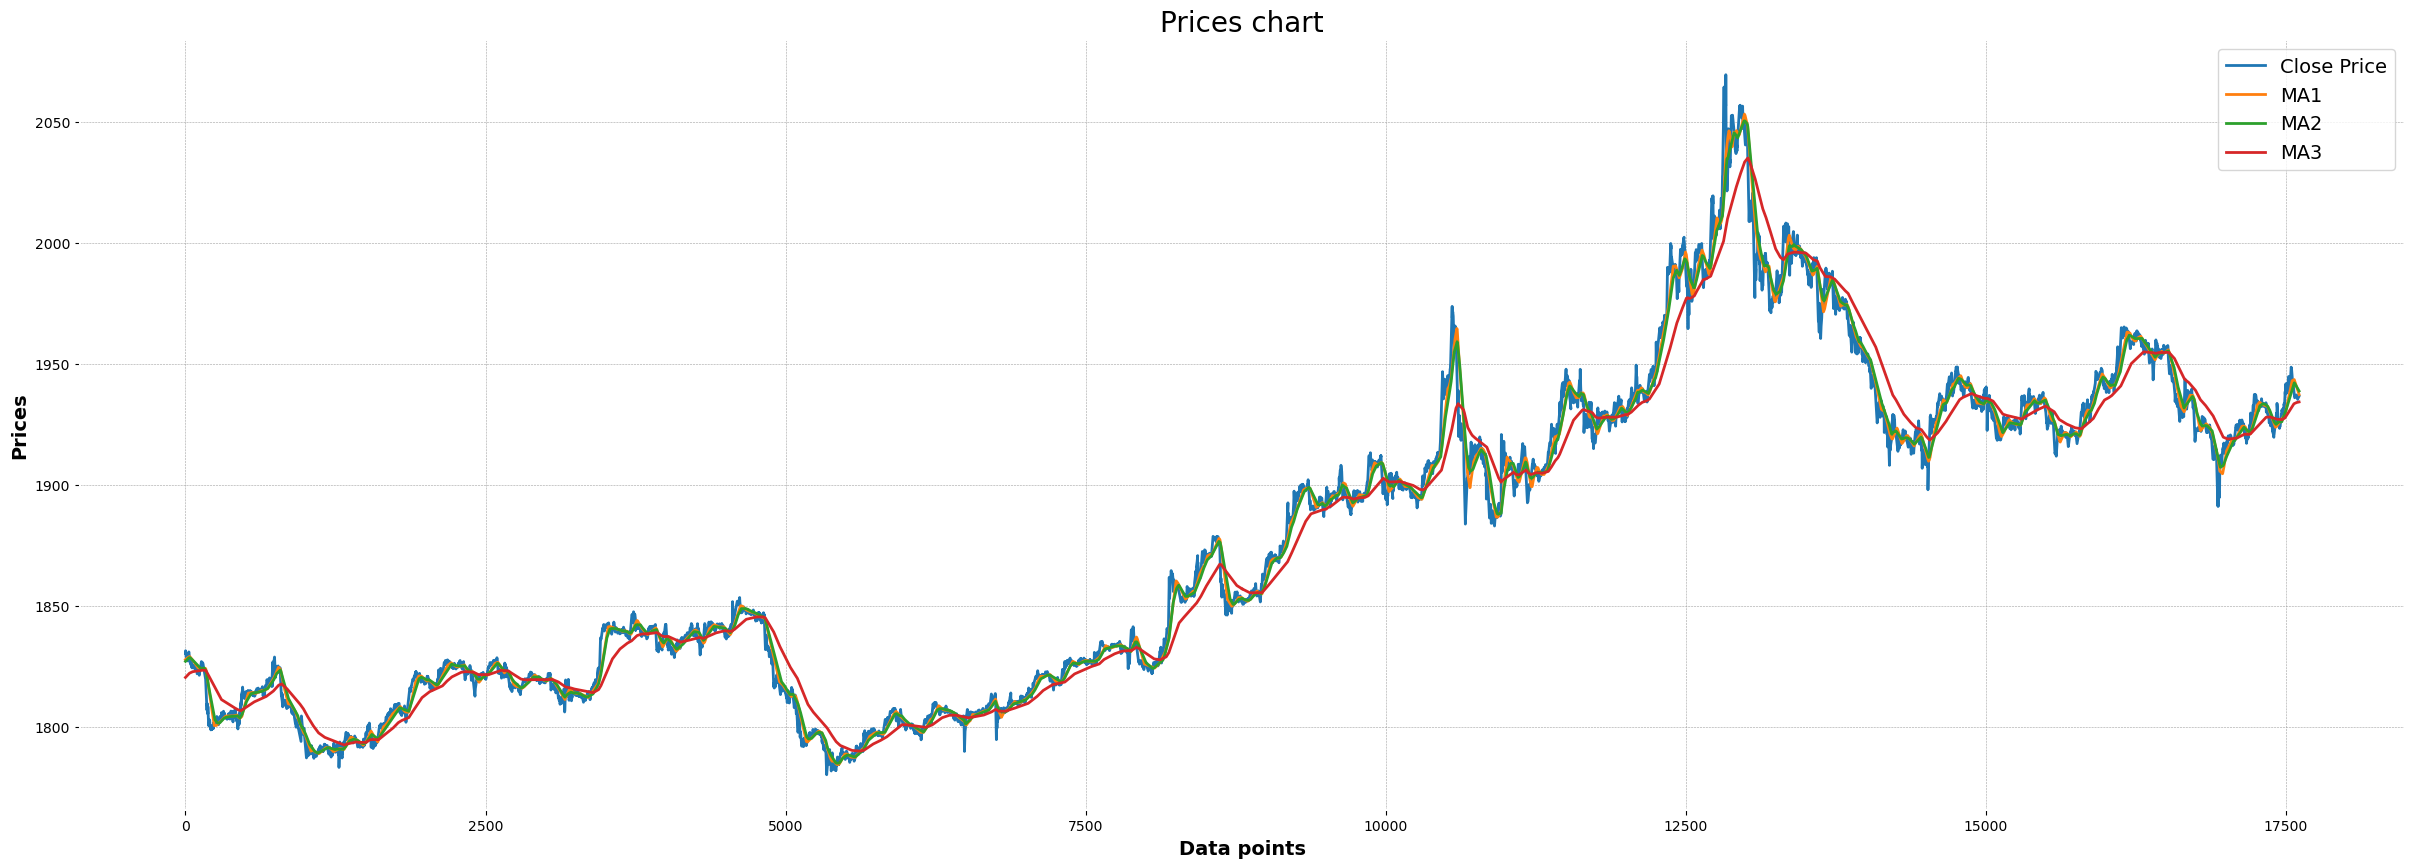

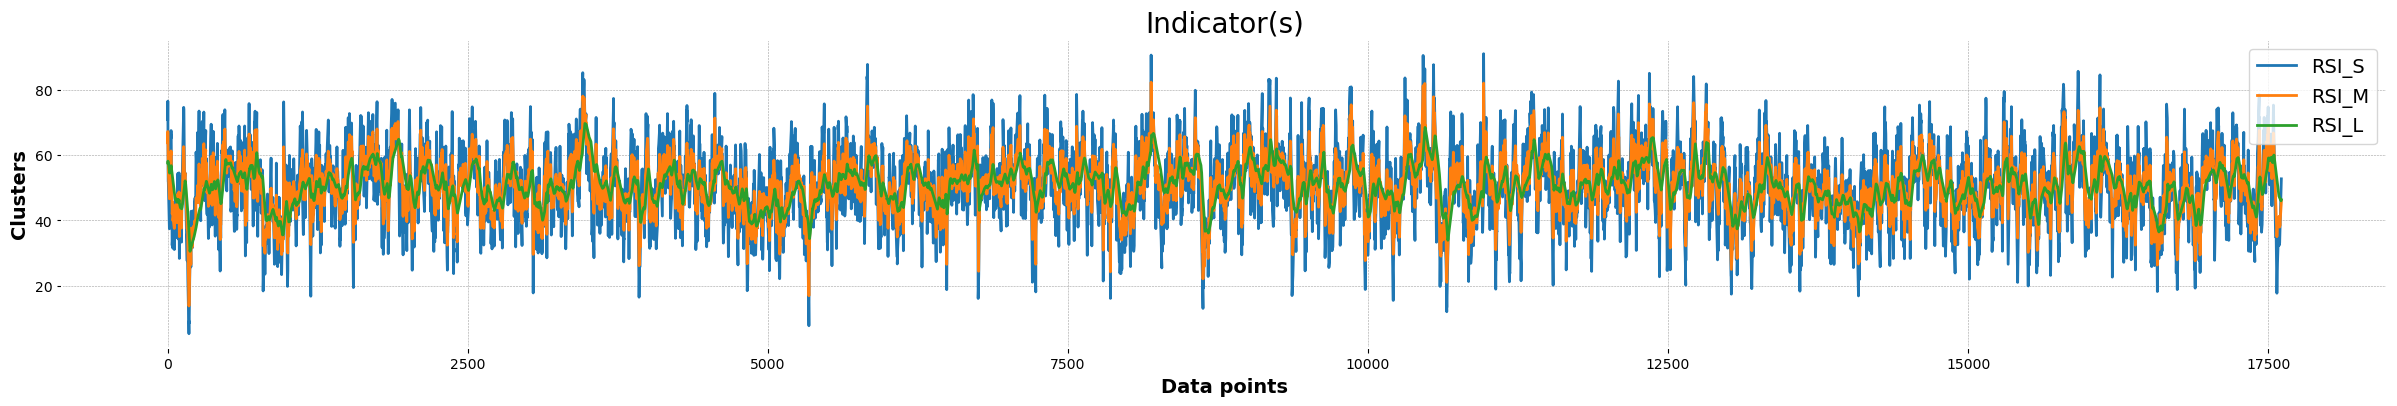

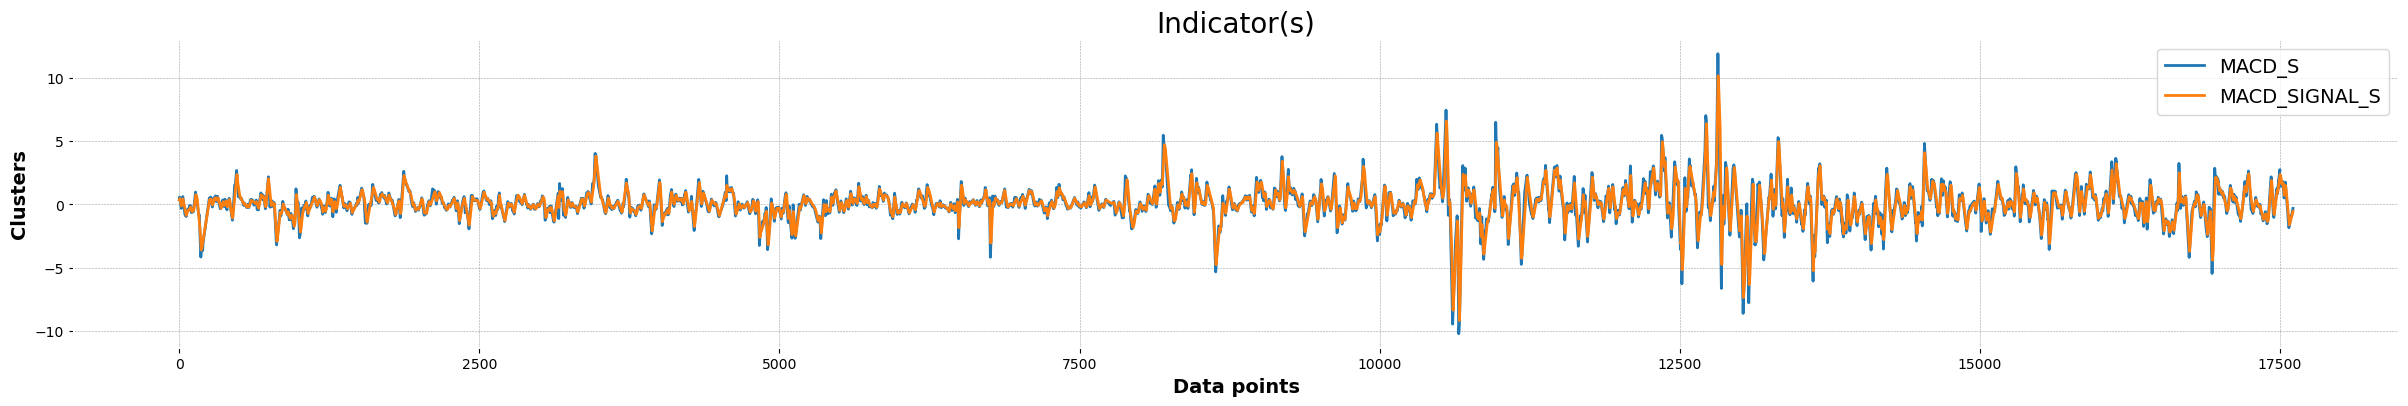

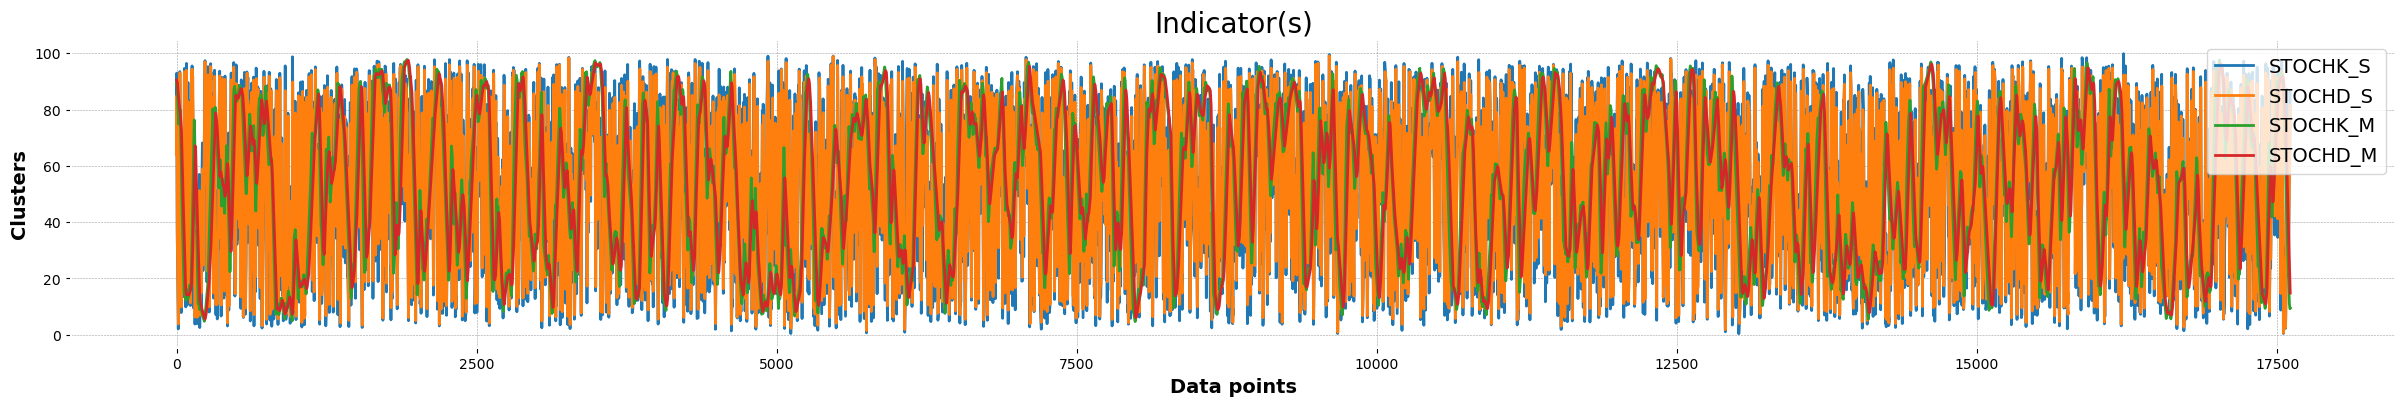

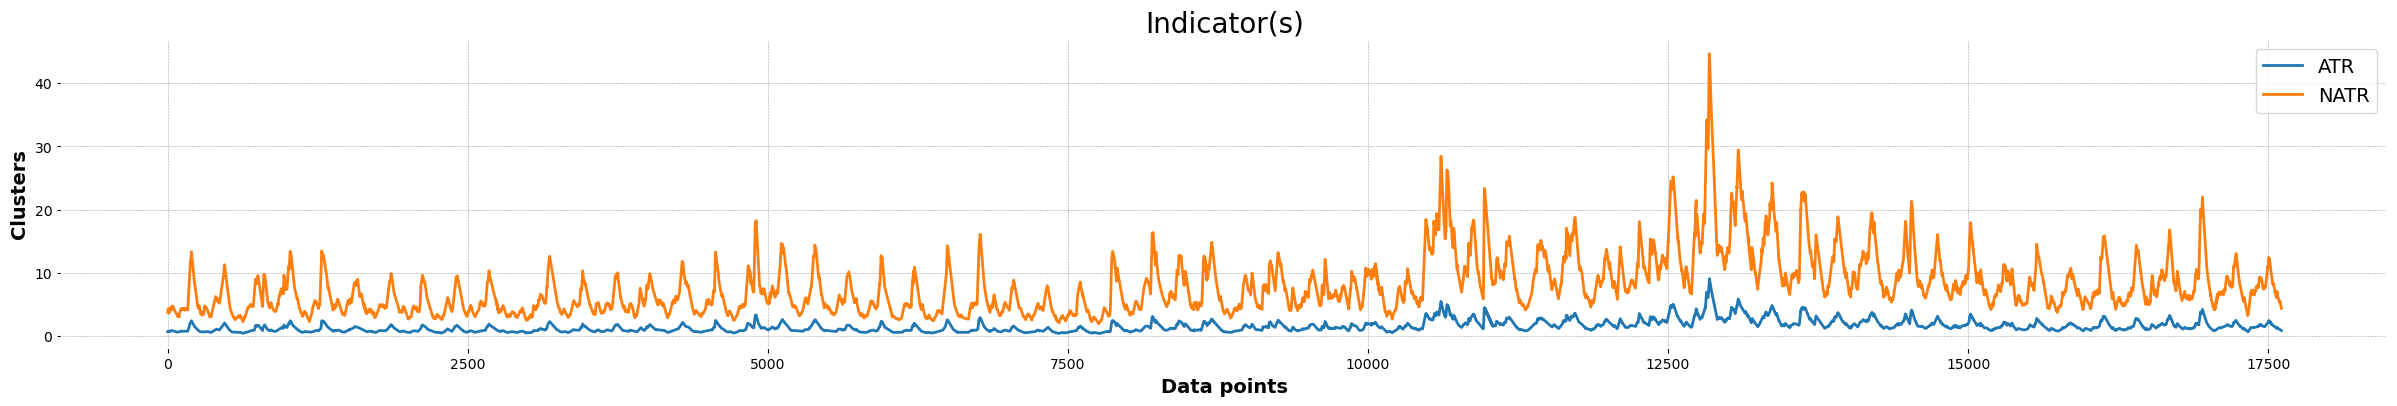

In [768]:
# Setting

df_indi = pd.DataFrame(dataset, copy=True)
total_rows = df_indi.shape[0]

# Get sub data
df = data_range(df_indi, from_date=date_start, to_date=date_end, window=window_chart)
new_total_rows = df.shape[0]
    
#===============================================================================================

# Plot price chart

plt.figure(figsize=(chart_width, chart_height))

x = np.arange(new_total_rows)
y = df['CLOSE']
plt.plot(x, y, label='Close Price')

x = np.arange(new_total_rows)
y = df['MA1']
plt.plot(x, y, label='MA1')

x = np.arange(new_total_rows)
y = df['MA2']
plt.plot(x, y, label='MA2')

x = np.arange(new_total_rows)
y = df['MA3']
plt.plot(x, y, label='MA3')

plt.xlabel('Data points', fontsize=14)
plt.ylabel('Prices', fontsize=14)
plt.title('Prices chart', fontsize=20)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

def plot_indi(data, cols):    
    for i in range(0, len(cols)):
        x = np.arange(new_total_rows)
        y = data[cols[i]]
        plt.plot(x, y, label=cols[i])

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['RSI_S', 'RSI_M', 'RSI_L'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['MACD_S', 'MACD_SIGNAL_S'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['STOCHK_S', 'STOCHD_S', 'STOCHK_M', 'STOCHD_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['ATR', 'NATR'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

## Create first signals using single rule

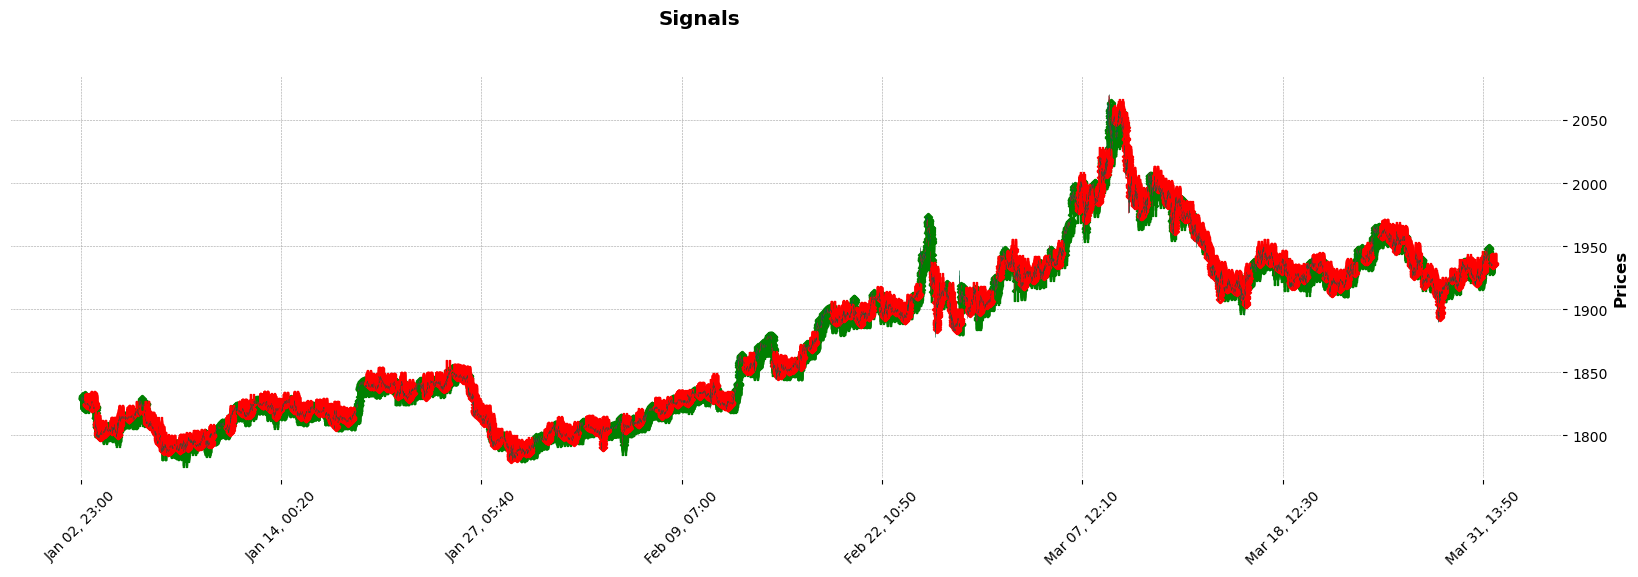

In [769]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((dataset['MA1'] > dataset['MA2'])
                             , 1, 0)

# Predict open sell / short signal
dataset['SIGNAL'] = np.where((dataset['MA1'] < dataset['MA2'])
                             , 11, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

## Remove exceeded signals

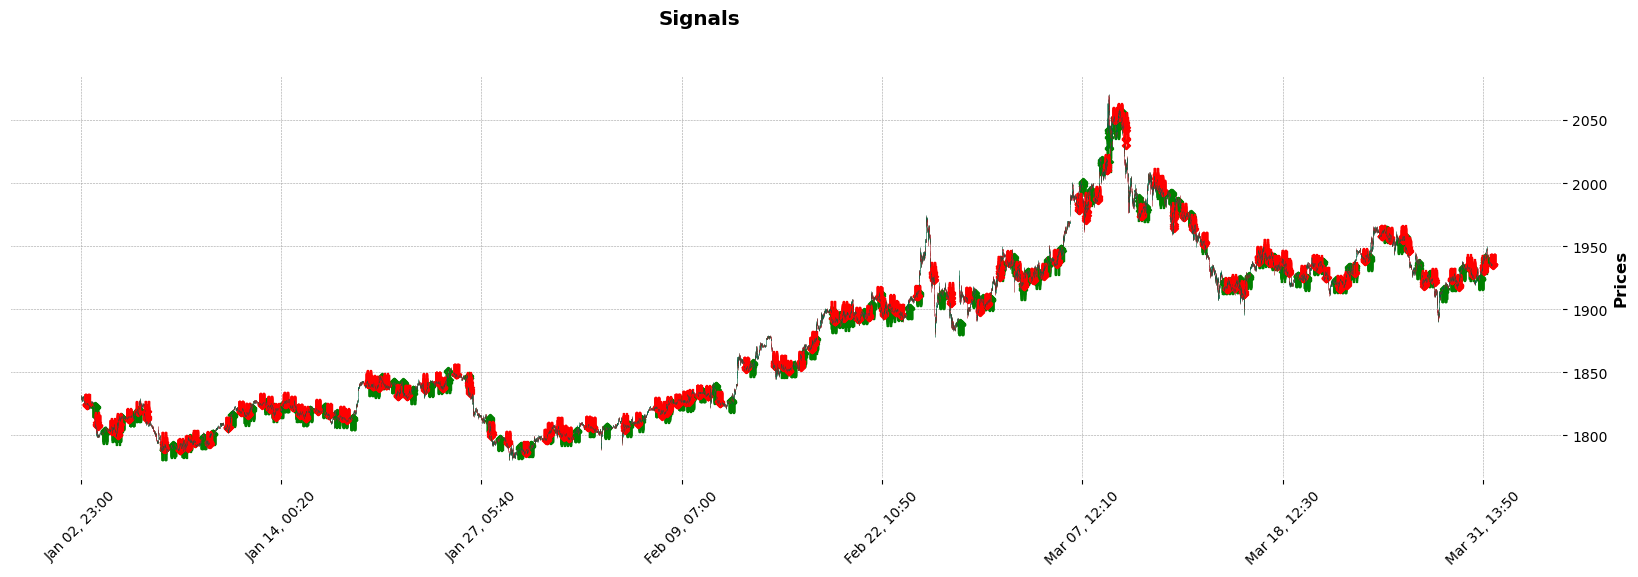

In [770]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((dataset['MA1'] > dataset['MA2'])
                             , 1, 0)

# Predict open sell / short signal
dataset['SIGNAL'] = np.where((dataset['MA1'] < dataset['MA2'])
                             , 11, dataset['SIGNAL'])

# Remove exceeded open buy and open sell signals
dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

## Create signals using multiple rules and using '&'

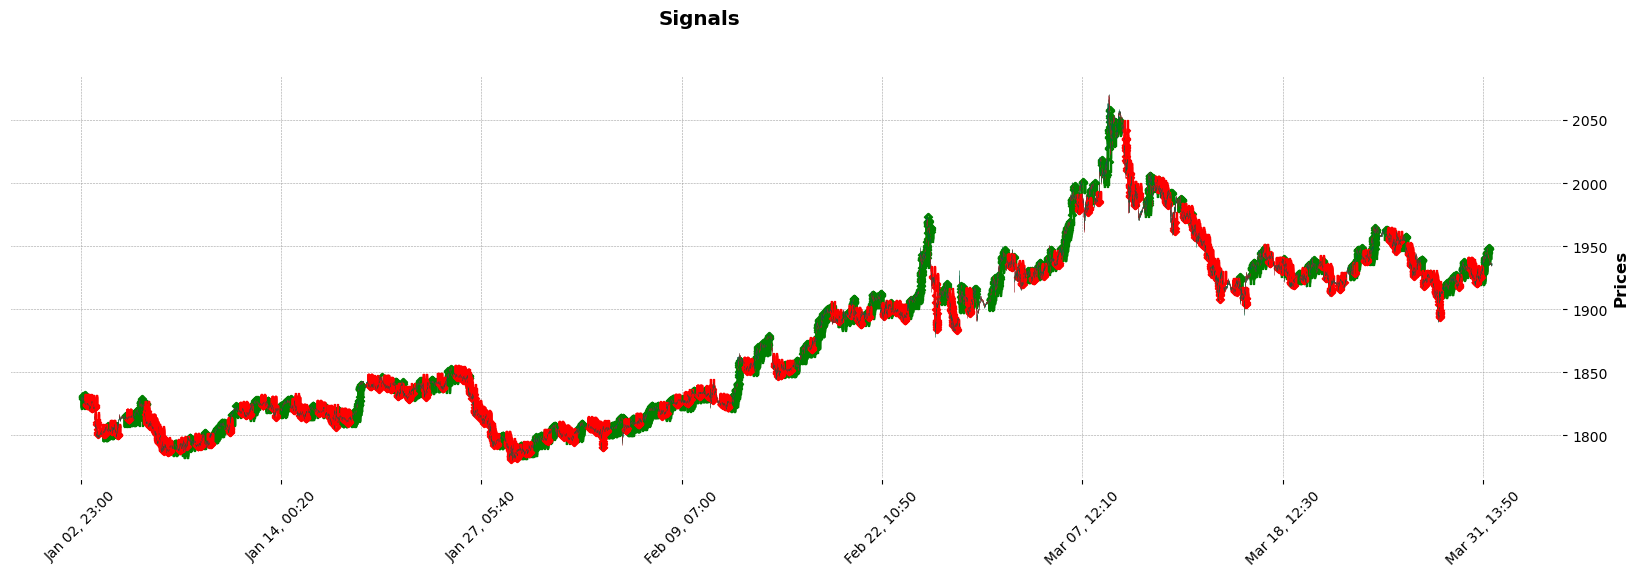

In [771]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((dataset['MA1'] > dataset['MA2'])
                             & (dataset['MACD_S'] > dataset['MACD_SIGNAL_S'])
                             & (dataset['MACD_S'] > 0)
                             , 1, 0)

# Predict open sell / short signal
dataset['SIGNAL'] = np.where((dataset['MA1'] < dataset['MA2'])
                             & (dataset['MACD_S'] < dataset['MACD_SIGNAL_S'])
                             & (dataset['MACD_S'] < 0)
                             , 11, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

## Create signals using multiple rules and using '|'

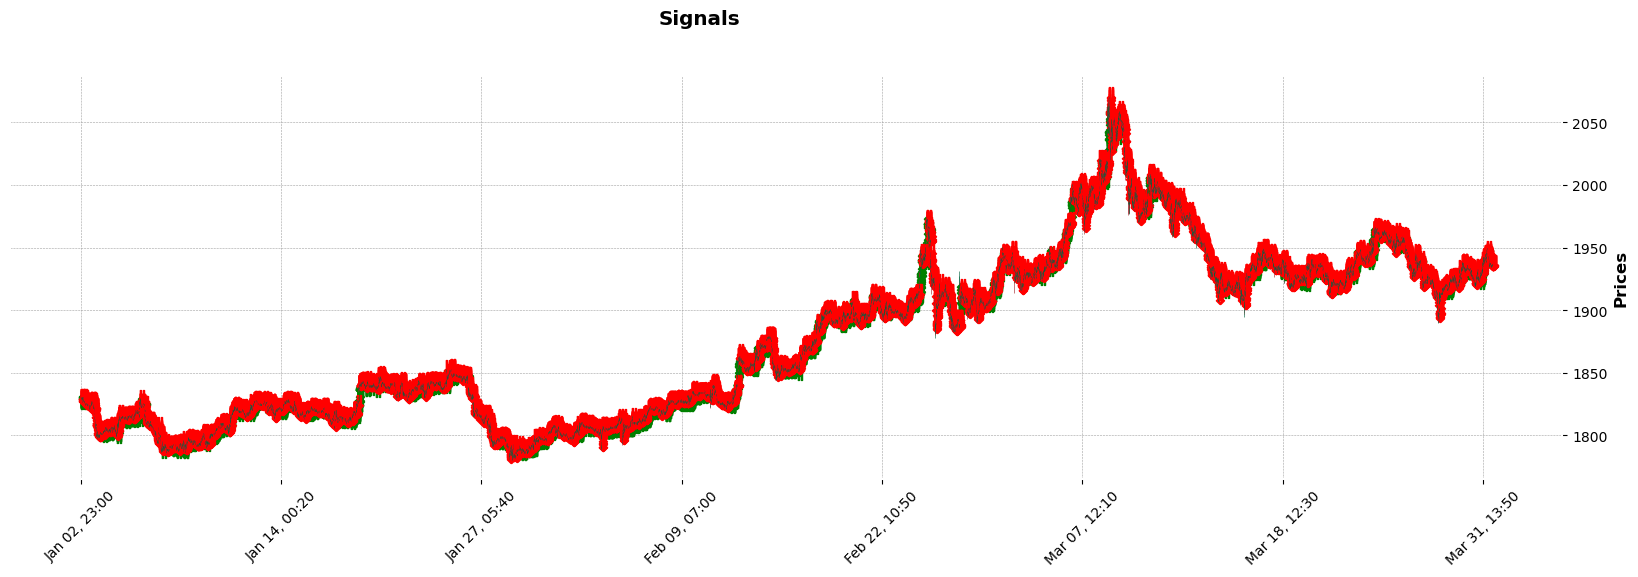

In [772]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((dataset['MA1'] > dataset['MA2'])
                             | (dataset['MACD_S'] > dataset['MACD_SIGNAL_S'])
                             | (dataset['RSI_M'] > 50)
                             , 1, 0)

# Predict open sell / short signal
dataset['SIGNAL'] = np.where((dataset['MA1'] < dataset['MA2'])
                             | (dataset['MACD_S'] < dataset['MACD_SIGNAL_S'])
                             | (dataset['RSI_M'] < 50)
                             , 11, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

## Create signals using multiple rules and using '&' and '|'

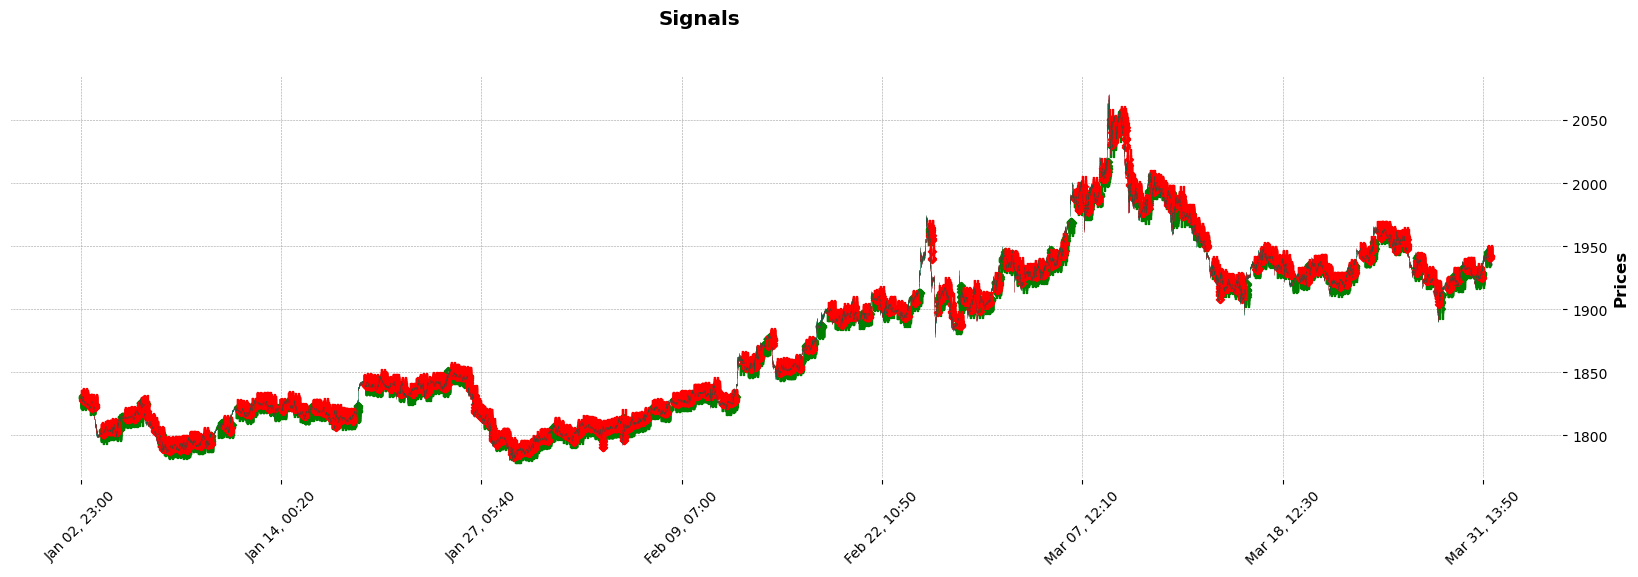

In [773]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where(((dataset['MA1'] > dataset['MA2'])
                                 & (dataset['MACD_S'] > dataset['MACD_SIGNAL_S'])
                                 & (dataset['MACD_S'] > 0))
                             | ((dataset['RSI_S'] > 50)
                                & (dataset['RSI_M'] > 50))
                             | ((dataset['STOCHK_M'] > dataset['STOCHD_M'])
                                & (dataset['STOCHD_M'] > 55))
                             , 1, 0)

# Predict open sell / short signal
dataset['SIGNAL'] = np.where(((dataset['MA1'] < dataset['MA2'])
                                 & (dataset['MACD_S'] < dataset['MACD_SIGNAL_S'])
                                 & (dataset['MACD_S'] < 0))
                             | ((dataset['RSI_S'] < 50)
                                & (dataset['RSI_M'] < 50))
                             | ((dataset['STOCHK_M'] < dataset['STOCHD_M'])
                                & (dataset['STOCHD_M'] < 45))
                             , 11, dataset['SIGNAL'])

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

## Create signals using rule 'under/over'

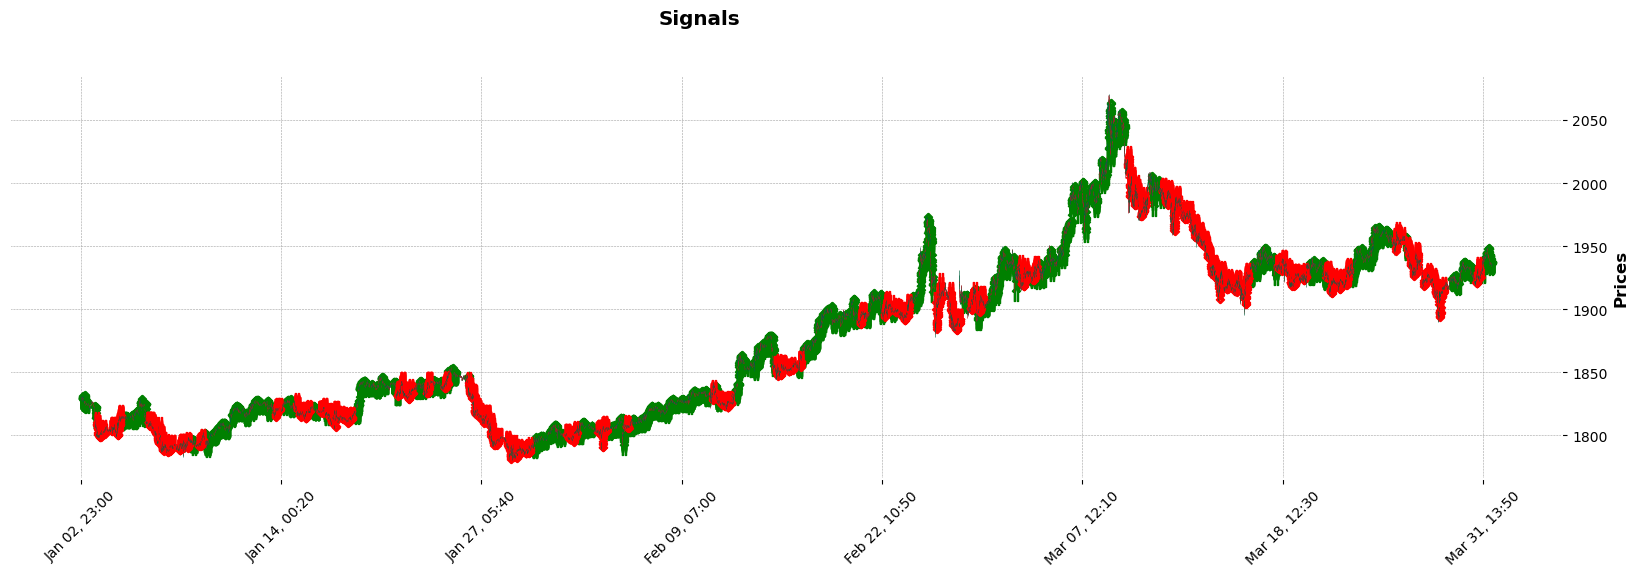

In [774]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((dataset['MA1'] > dataset['MA2'])
                             & (dataset['MA1'] > dataset['MA3'])
                             & (dataset['MA2'] > dataset['MA3'])
                             , 1, 0)

# Predict open sell / short signal
dataset['SIGNAL'] = np.where((dataset['MA1'] < dataset['MA2'])
                             & (dataset['MA1'] < dataset['MA3'])
                             & (dataset['MA2'] < dataset['MA3'])
                             , 11, dataset['SIGNAL'])

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

## Create signals using rule 'slope'

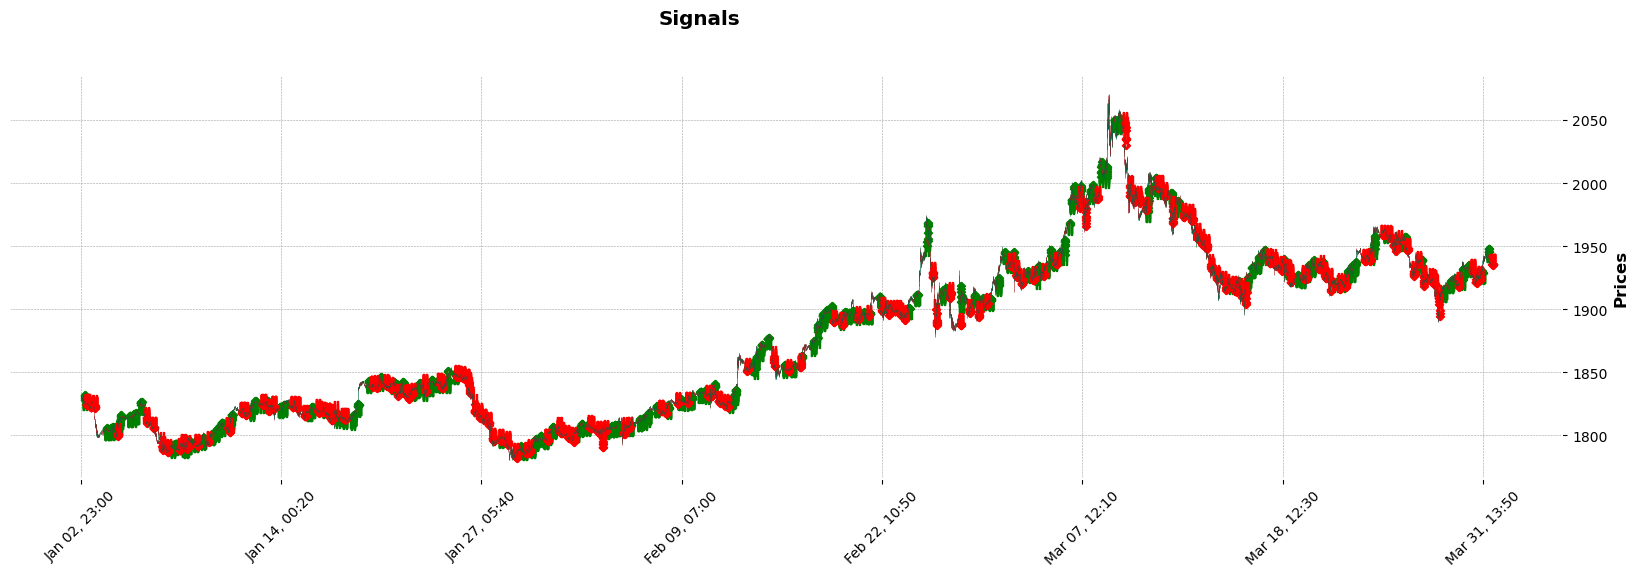

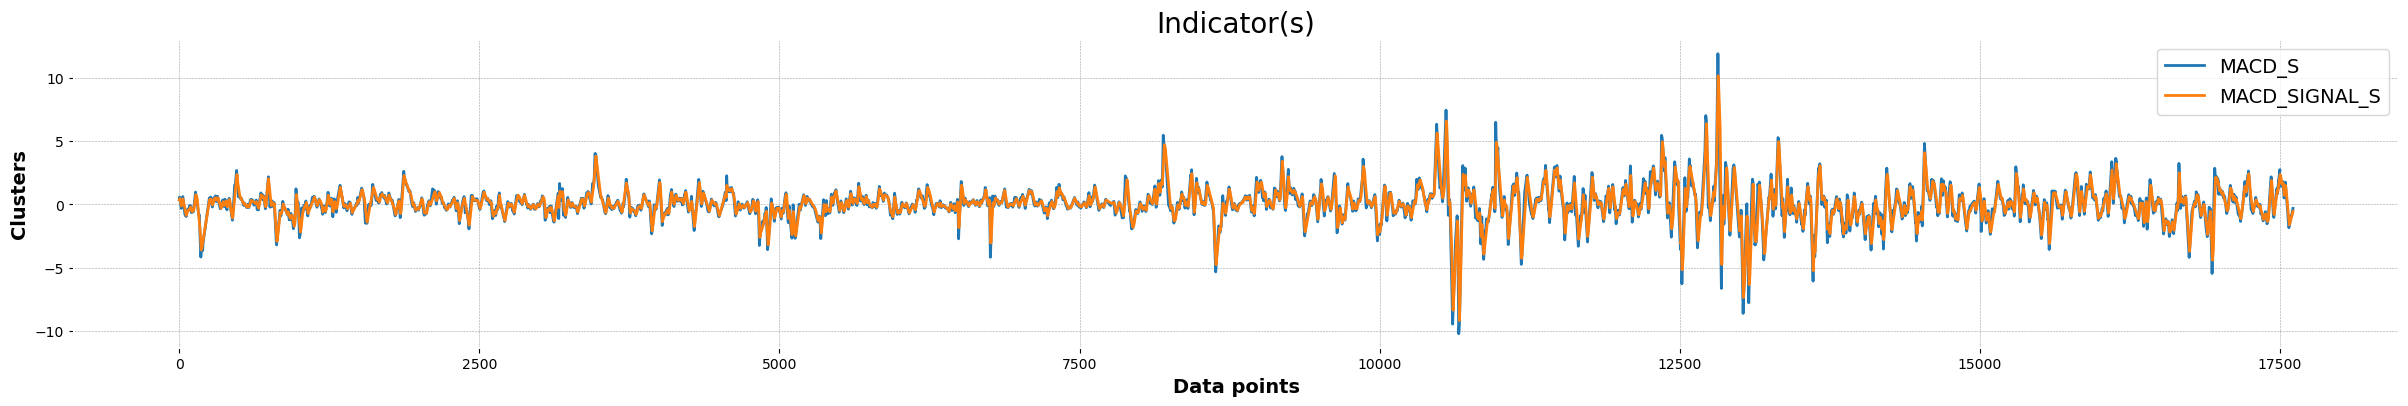

In [775]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((dataset['MA1'] > pdta.ema(dataset['MA2'], 50))
                             & (dataset['MACD_SIGNAL_S'] > pdta.ema(dataset['MACD_SIGNAL_S'], 50))
                             , 1, 0)

# Predict open sell / short signal
dataset['SIGNAL'] = np.where((dataset['MA1'] < pdta.ema(dataset['MA2'], 50))
                             & (dataset['MACD_SIGNAL_S'] < pdta.ema(dataset['MACD_SIGNAL_S'], 50))
                             , 11, dataset['SIGNAL'])

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['MACD_S', 'MACD_SIGNAL_S'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

## Create signals using rule 'cross'

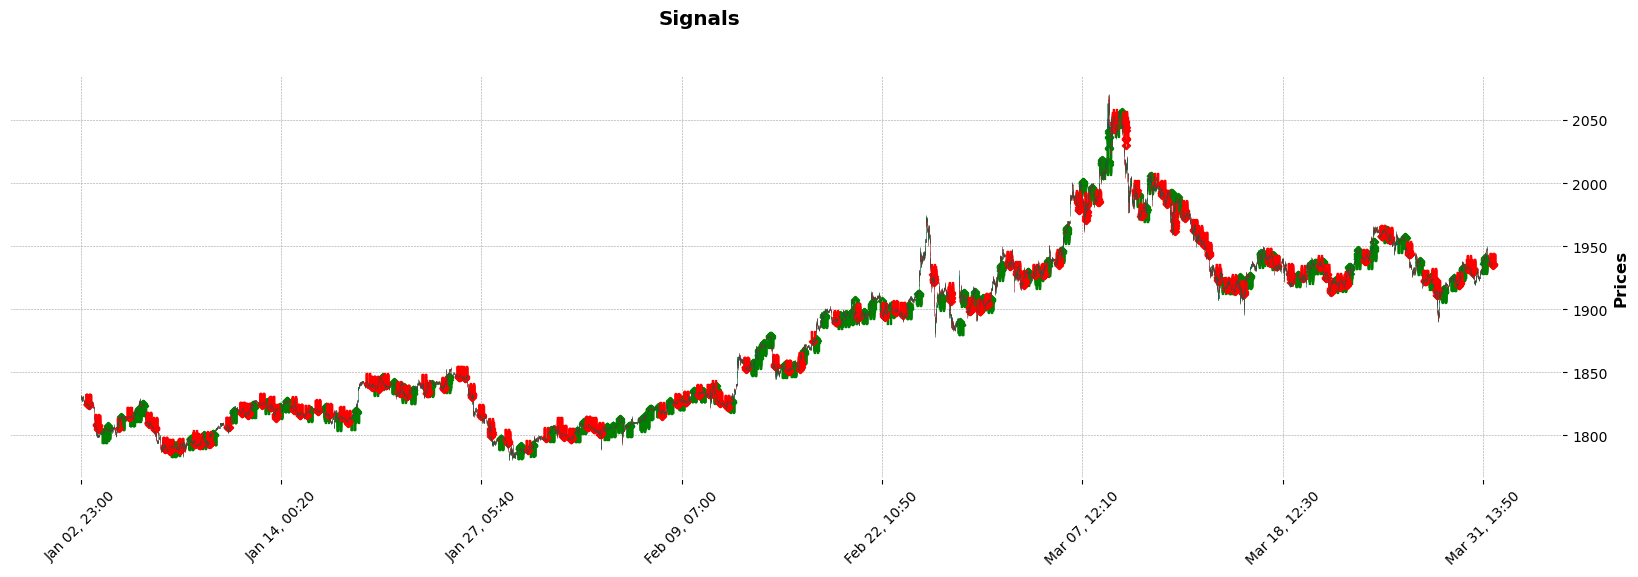

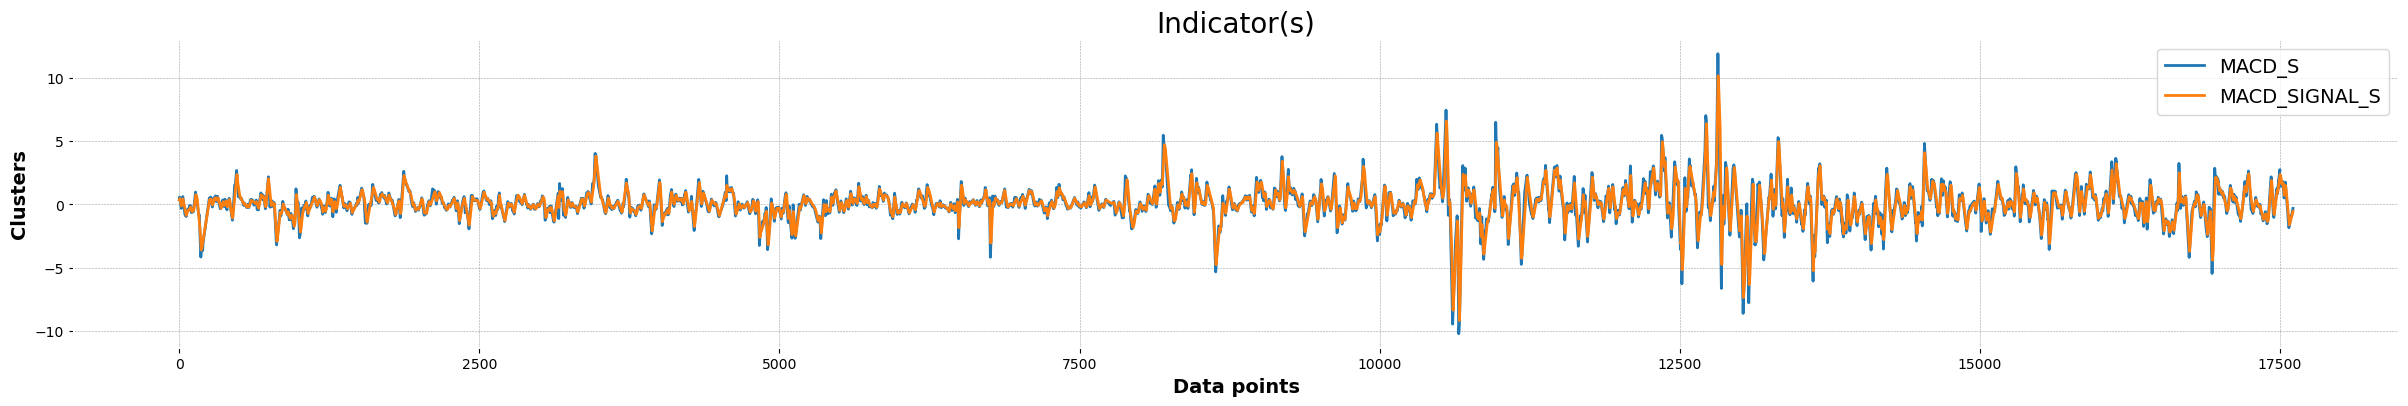

In [776]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((dataset['MACD_SIGNAL_S'] > 0)
                             & (FELib.llv(dataset['MACD_SIGNAL_S'], 30) > 0)
                             & (FELib.llv(dataset['MACD_SIGNAL_S'], 40) < 0)
                             , 1, 0)

# Predict open sell / short signal
dataset['SIGNAL'] = np.where((dataset['MACD_SIGNAL_S'] < 0)
                             & (FELib.hhv(dataset['MACD_SIGNAL_S'], 30) < 0)
                             & (FELib.hhv(dataset['MACD_SIGNAL_S'], 40) > 0)
                             , 11, dataset['SIGNAL'])

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['MACD_S', 'MACD_SIGNAL_S'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

## Create signals using rule 'break'

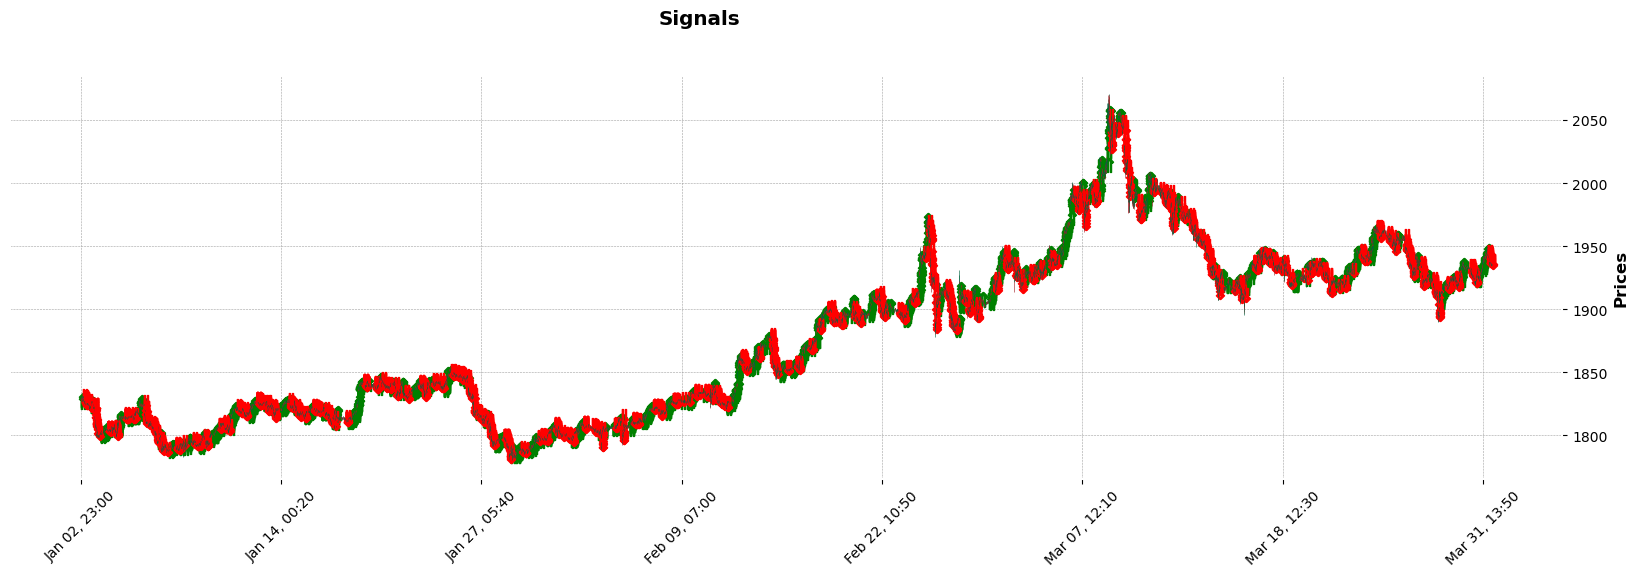

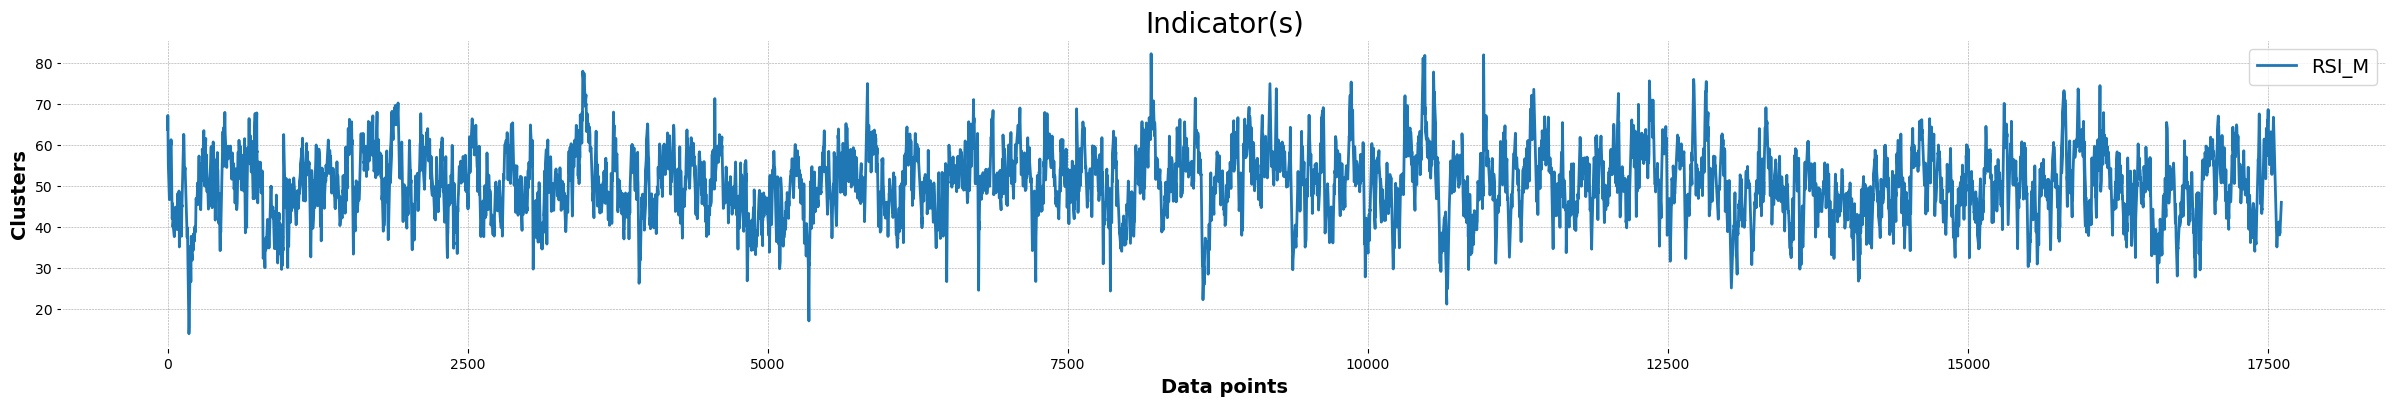

In [777]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((dataset['CLOSE'] == FELib.hhv(dataset['CLOSE'], 100))
                             | (dataset['RSI_M'] == FELib.hhv(dataset['RSI_M'], 100))
                             | (dataset['MACD_SIGNAL_S'] == FELib.hhv(dataset['MACD_SIGNAL_S'], 100))
                             , 1, 0)

# Predict open sell / short signal
dataset['SIGNAL'] = np.where((dataset['CLOSE'] == FELib.llv(dataset['CLOSE'], 100))
                             | (dataset['RSI_M'] == FELib.llv(dataset['RSI_M'], 100))
                             | (dataset['MACD_SIGNAL_S'] == FELib.llv(dataset['MACD_SIGNAL_S'], 100))
                             , 11, dataset['SIGNAL'])

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['RSI_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

## Create signals using rule 'strong trend'

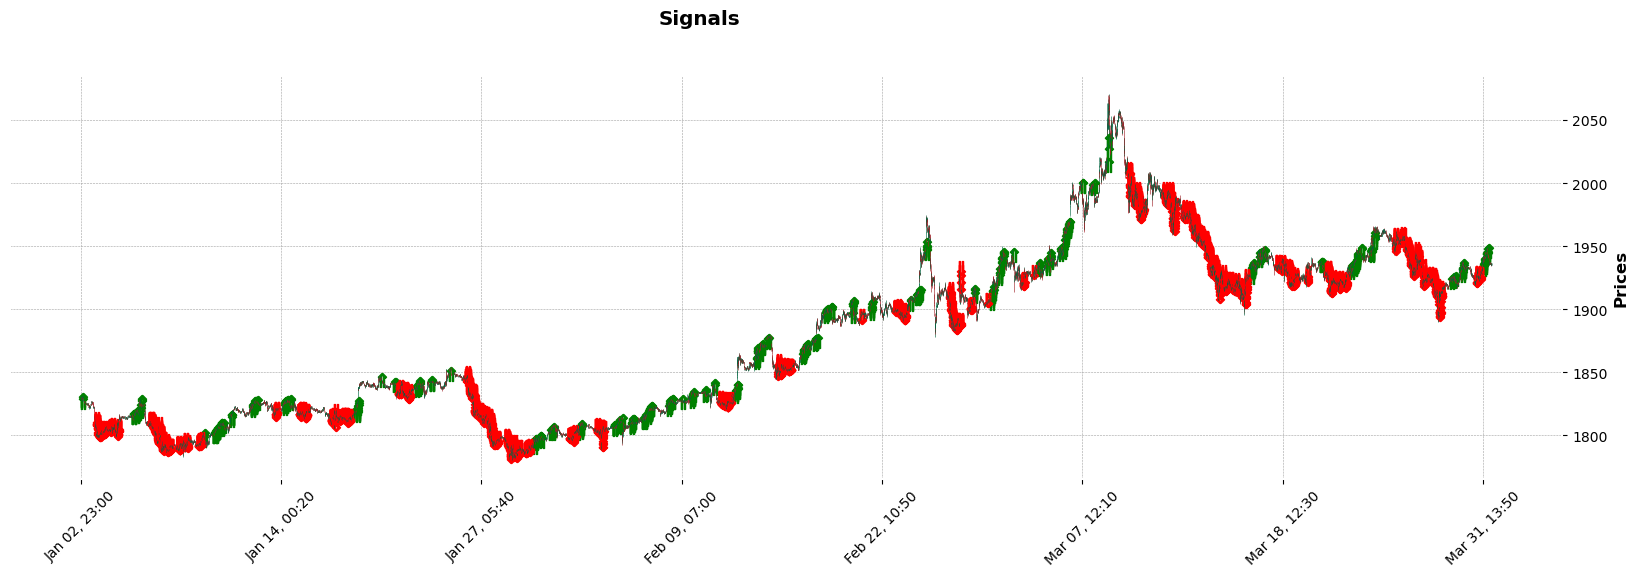

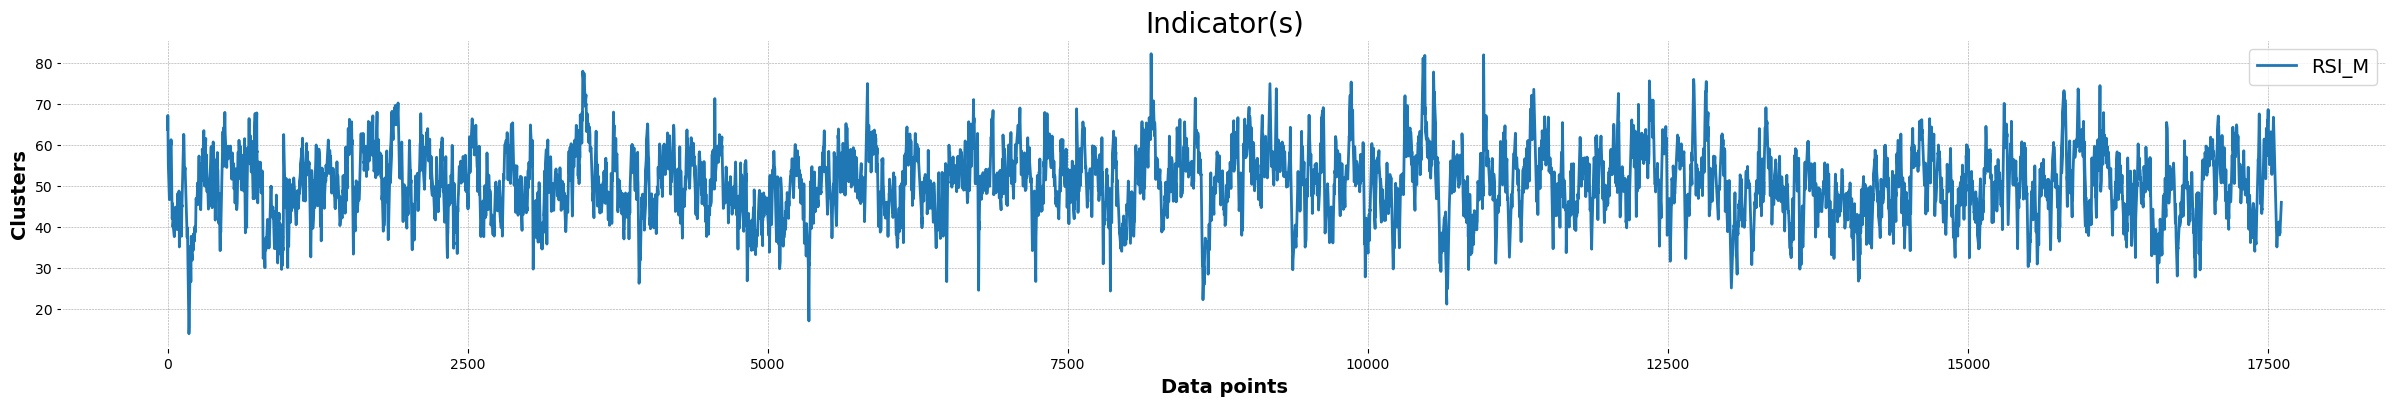

In [778]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((dataset['CLOSE'] == FELib.hhv(dataset['CLOSE'], 100))
                             & (dataset['MA1'] == FELib.hhv(dataset['MA1'], 50))
                             & (dataset['MACD_SIGNAL_S'] > 0)
                             & (dataset['MACD_S'] > dataset['MACD_SIGNAL_S'])
                             & (dataset['RSI_M'] < 70)
                             & (pdta.ema(dataset['RSI_M'], 300) > 45)
                             & (pdta.ema(dataset['RSI_L'], 300) > 45)
                             & (pdta.ema(dataset['STOCHK_S'], 300) > 45)
                             & (pdta.ema(dataset['MA2'], 5) > pdta.ema(dataset['MA2'], 100))
                             & (dataset['MA2'] > dataset['MA3'])
                             , 1, 0)

# Predict open sell / short signal
dataset['SIGNAL'] = np.where((pdta.ema(dataset['RSI_M'], 300) < 50)
                             & (pdta.ema(dataset['RSI_L'], 300) < 50)
                             & (pdta.ema(dataset['STOCHK_S'], 100) < 50)
                             & (pdta.ema(dataset['MACD_SIGNAL_S'], 100) < 0)
                             , 11, dataset['SIGNAL'])

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['RSI_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

## Create signals using rule 'reverse up/down'

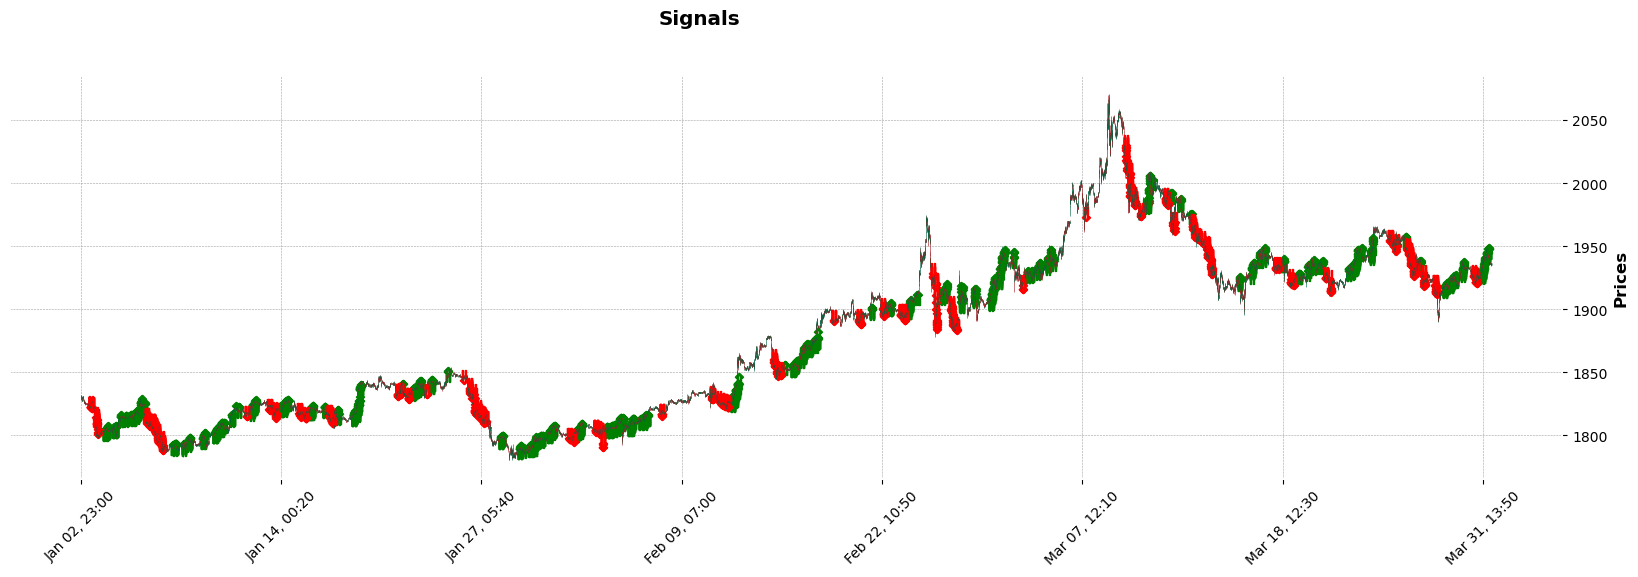

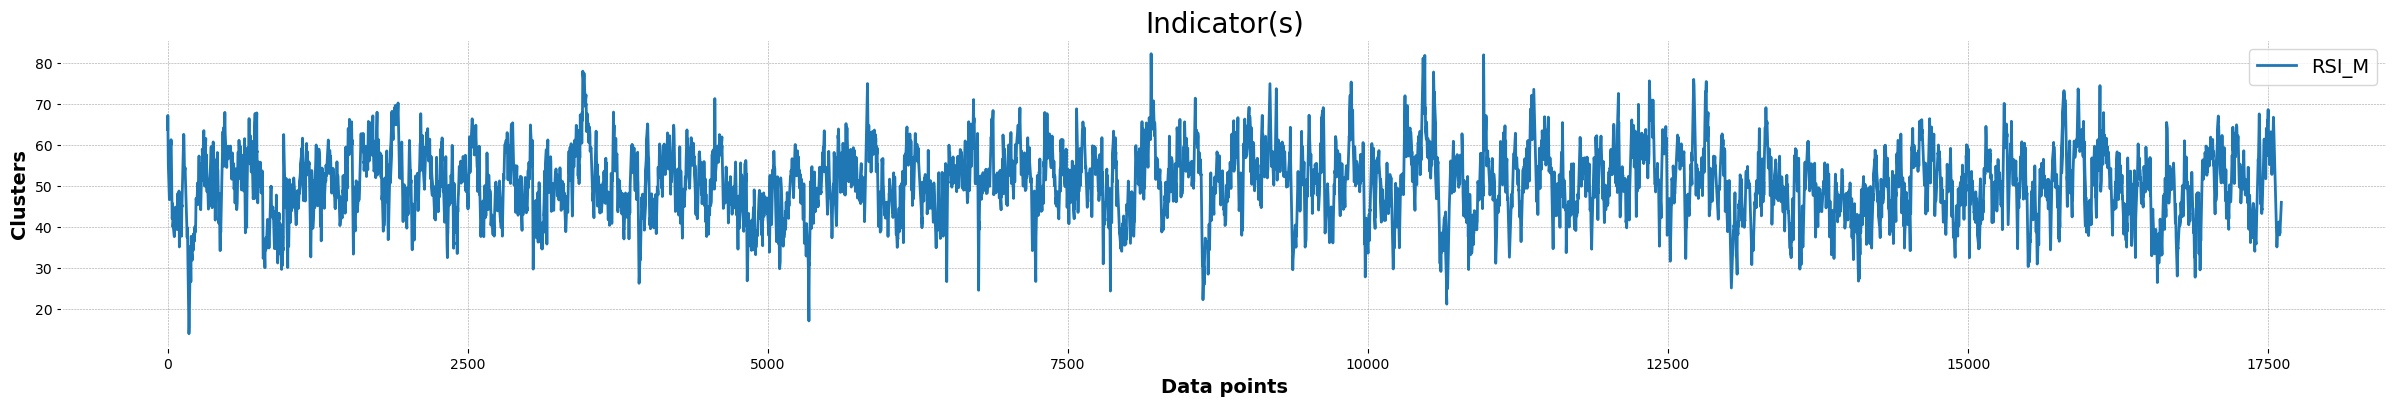

In [779]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((dataset['MA1'] == FELib.hhv(dataset['MA1'], 50))
                             & (dataset['MACD_SIGNAL_S'] > 0)
                             & (dataset['MACD_S'] > dataset['MACD_SIGNAL_S'])
                             & (dataset['RSI_M'] > 50)
                             & (FELib.llv(dataset['RSI_M'], 1000) < 35)
                             & (dataset['RSI_L'] > 45)
                             #& (FELib.llv(dataset['RSI_L'], 5000) < 35)
                             & (FELib.llv(dataset['STOCHK_M'], 2000) < 30)
                             & (FELib.hhv(dataset['MA2'], 2000) > dataset['MA2'])
                             & (FELib.hhv(dataset['MA3'], 2000) > dataset['MA3'])
                             & (FELib.llv(dataset['MACD_SIGNAL_S'], 2000) < 0)
                             #& (dataset['MA3'] > pdta.ema(dataset['MA3'], 1000))
                             , 1, 0)

# Predict open sell / short signal
dataset['SIGNAL'] = np.where((dataset['MA1'] == FELib.llv(dataset['MA1'], 50))
                             & (dataset['MACD_SIGNAL_S'] < 0)
                             & (dataset['MACD_S'] < dataset['MACD_SIGNAL_S'])
                             & (dataset['RSI_M'] < 45)
                             & (FELib.hhv(dataset['RSI_M'], 1000) > 65)
                             & (dataset['RSI_L'] < 45)
                             & (FELib.hhv(dataset['STOCHK_M'], 2000) > 65)
                             & (FELib.llv(dataset['MA2'], 2000) < dataset['MA2'])
                             & (FELib.llv(dataset['MA3'], 2000) < dataset['MA3'])
                             & (FELib.hhv(dataset['MACD_SIGNAL_S'], 2000) > 0)
                             #& (dataset['MA3'] < pdta.ema(dataset['MA3'], 1000))
                             , 11, dataset['SIGNAL'])

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['RSI_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

## Create signals using rule 'rebound'

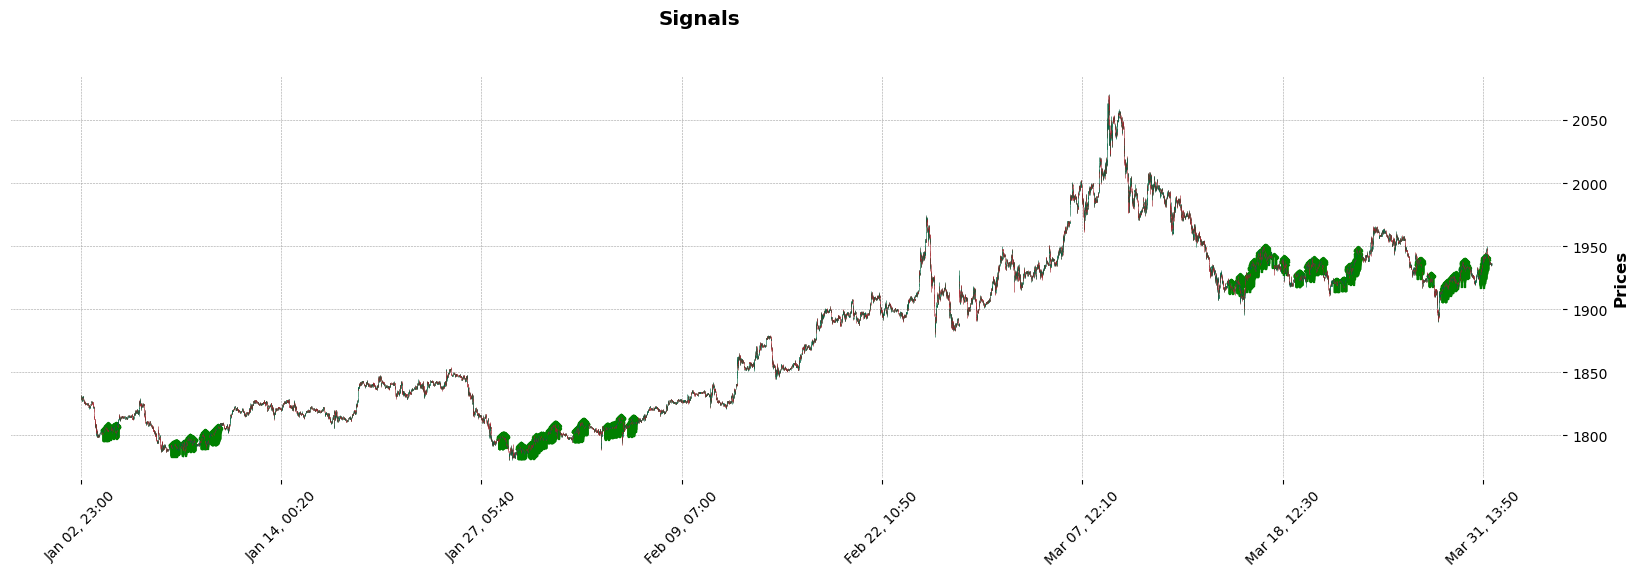

In [780]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((dataset['MA1'] == FELib.hhv(dataset['MA1'], 50))
                             & (pdta.ema(dataset['MACD_SIGNAL_S'], 3000) < 0)
                             & (dataset['RSI_M'] > 50)
                             & (FELib.hhv(dataset['MA2'], 3000) > dataset['MA2'])
                             & (FELib.llv(dataset['MACD_SIGNAL_S'], 2000) < 0)
                             , 1, 0)

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

## Create signals using rule 'correction'

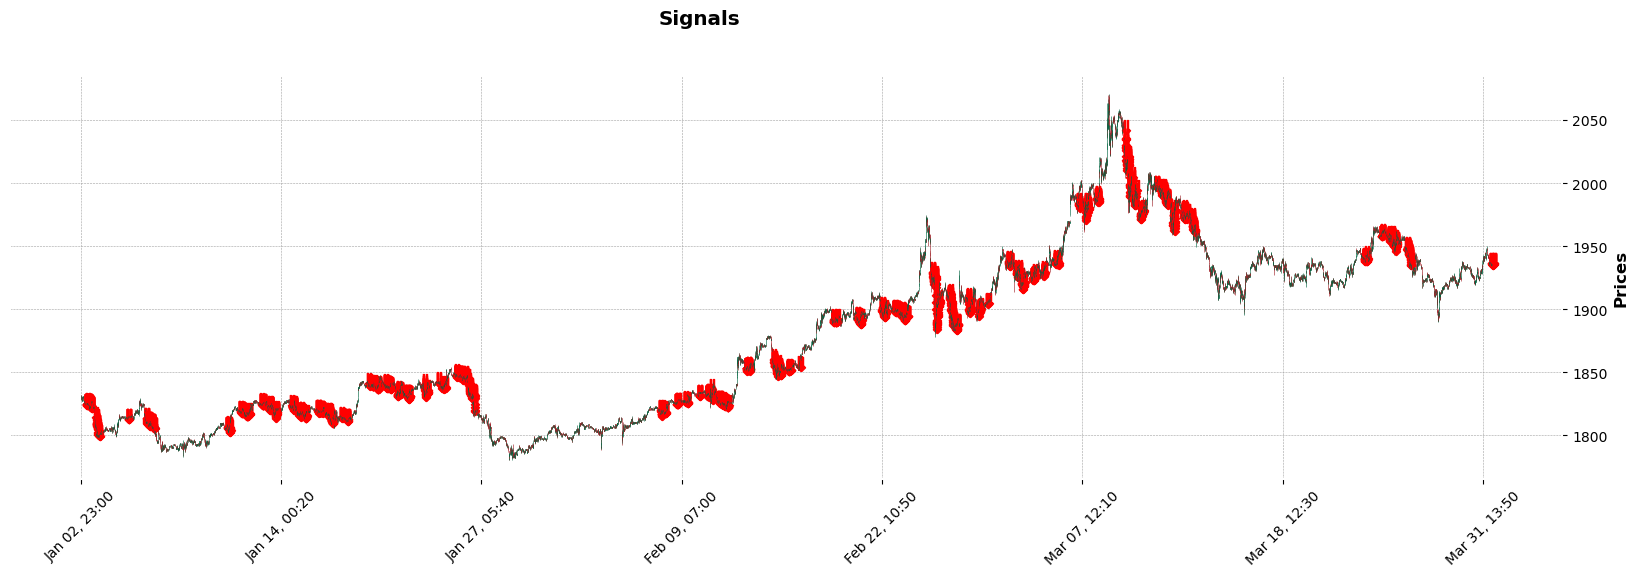

In [781]:
# Predict open sell / short signal
dataset['SIGNAL'] = np.where((dataset['MA1'] == FELib.llv(dataset['MA1'], 50))
                             & (pdta.ema(dataset['MACD_SIGNAL_S'], 3000) > 0)
                             & (dataset['RSI_M'] < 50)
                             & (FELib.llv(dataset['MA2'], 3000) < dataset['MA2'])
                             & (FELib.hhv(dataset['MACD_SIGNAL_S'], 2000) > 0)
                             , 11, 0)

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

## Create signals using rule 'high fluctuation'

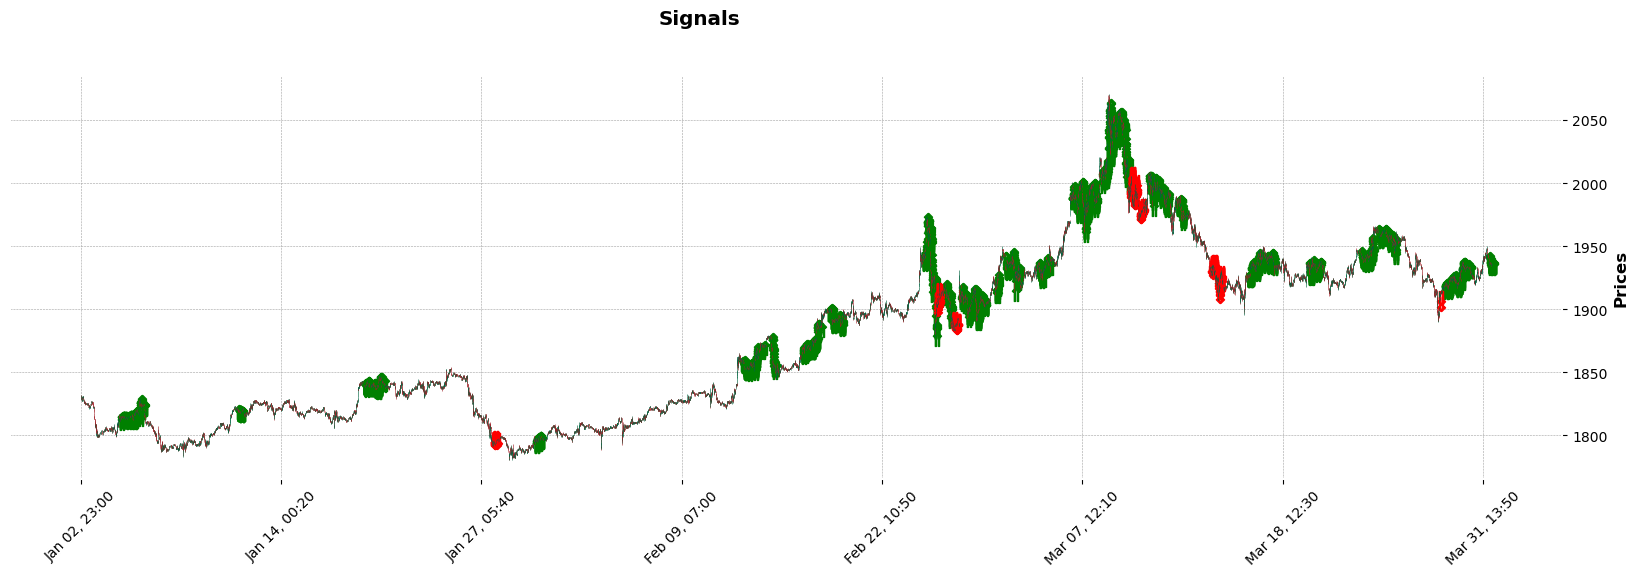

In [782]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((dataset['MA1'] > pdta.ema(dataset['MA1'], 1000) * 1.02)
                             & (dataset['MA1'] == FELib.hhv(dataset['MA1'], 300))
                             , 1, 0)

dataset['SIGNAL'] = np.where((dataset['MA1'] > FELib.llv(dataset['MA1'], 300) * 1.005)
                             & (FELib.llv(dataset['MA1'], 300) < FELib.hhv(dataset['MA1'], 600) * 0.99)
                             & (FELib.hhv(dataset['MA1'], 600) > dataset['MA1'])
                             , 1, dataset['SIGNAL'])

# Predict open sell / short signal
dataset['SIGNAL'] = np.where((dataset['MA1'] < pdta.ema(dataset['MA1'], 300) * 0.99)
                             & (dataset['MA1'] == FELib.llv(dataset['MA1'], 300))
                             , 11, dataset['SIGNAL'])

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

## Create signals using rule 'just reach'

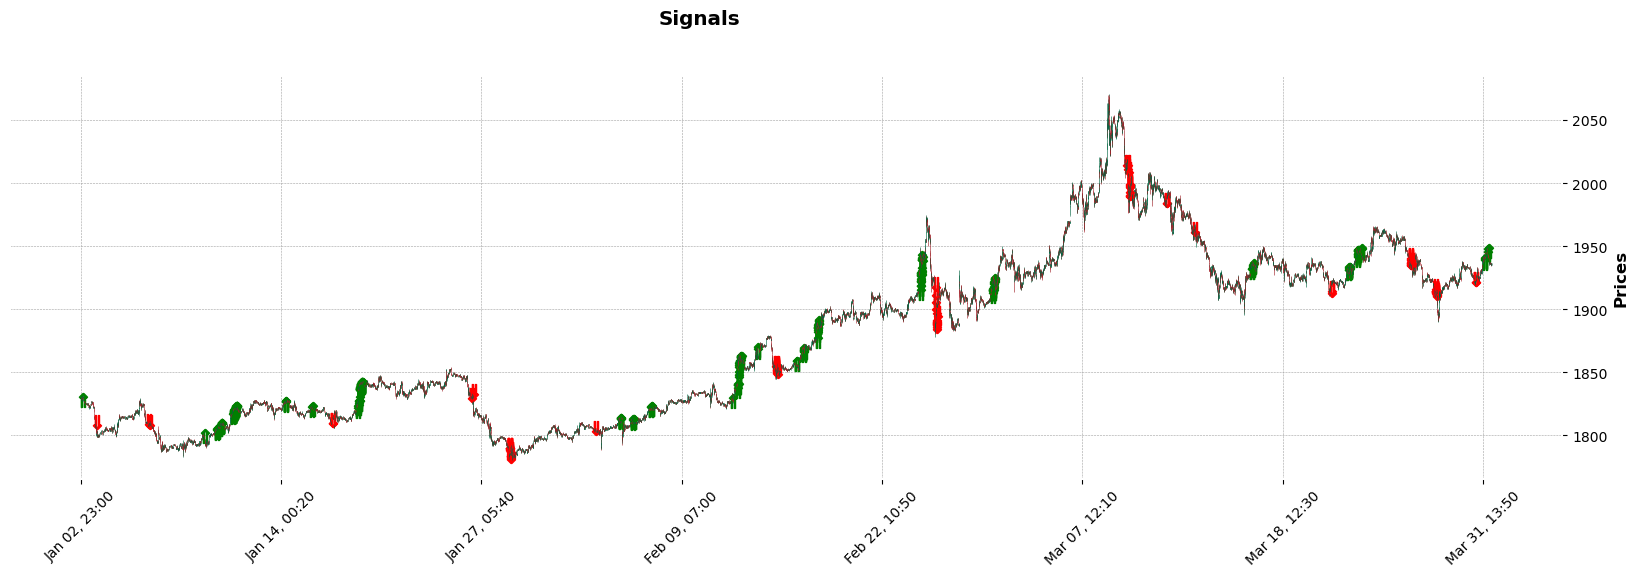

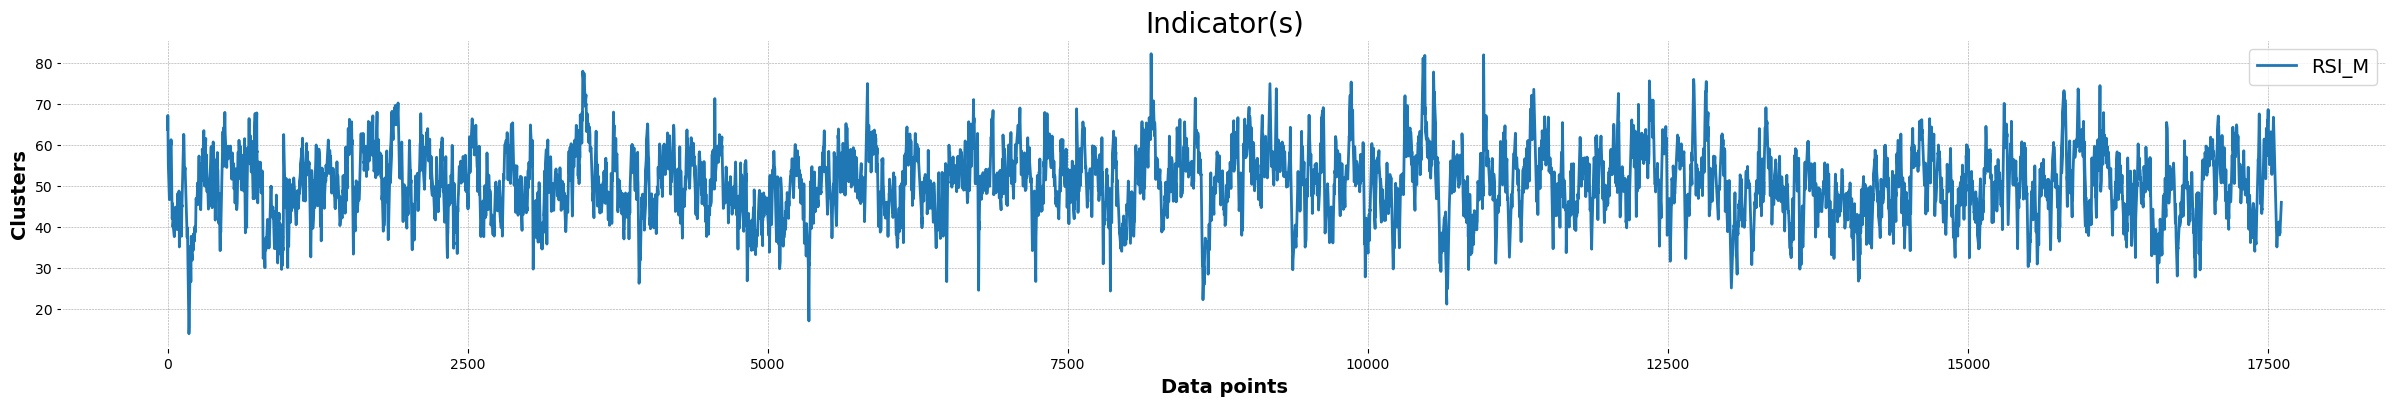

In [783]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((dataset['RSI_M'] > 65)
                             & (pdta.ema(dataset['RSI_M'], 900) < 65)
                             & (dataset['STOCHD_M'] > 80)
                             & (pdta.ema(dataset['STOCHD_M'], 900) < 80)
                             & (dataset['MA1'] < FELib.llv(dataset['MA1'], 900) * 1.02)
                             , 1, 0)

# Predict open sell / short signal
dataset['SIGNAL'] = np.where((dataset['RSI_M'] < 35)
                             & (pdta.ema(dataset['RSI_M'], 60) > 35)
                             & (dataset['STOCHD_M'] < 20)
                             & (pdta.ema(dataset['STOCHD_M'], 60) > 20)
                             #& (dataset['MA1'] > FELib.hhv(dataset['MA1'], 900) * 0.98)
                             , 11, dataset['SIGNAL'])

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['RSI_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

## Create signals using rule 'long stay'

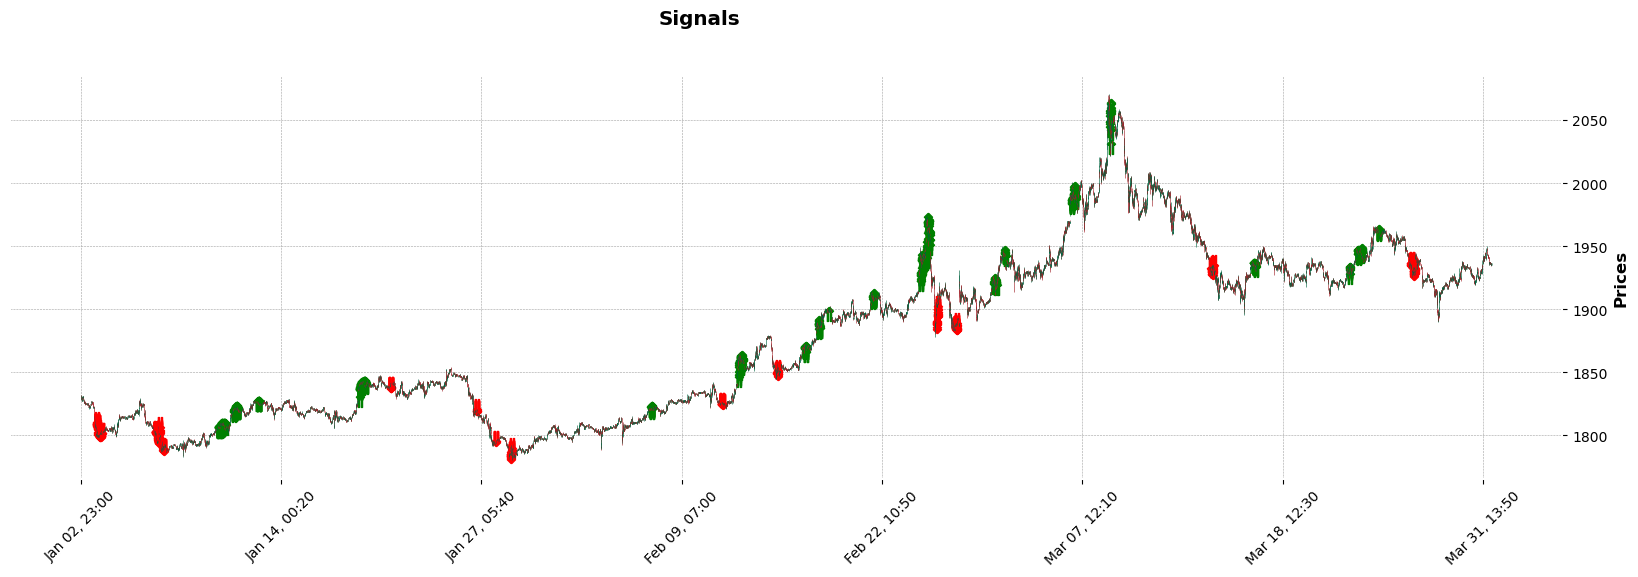

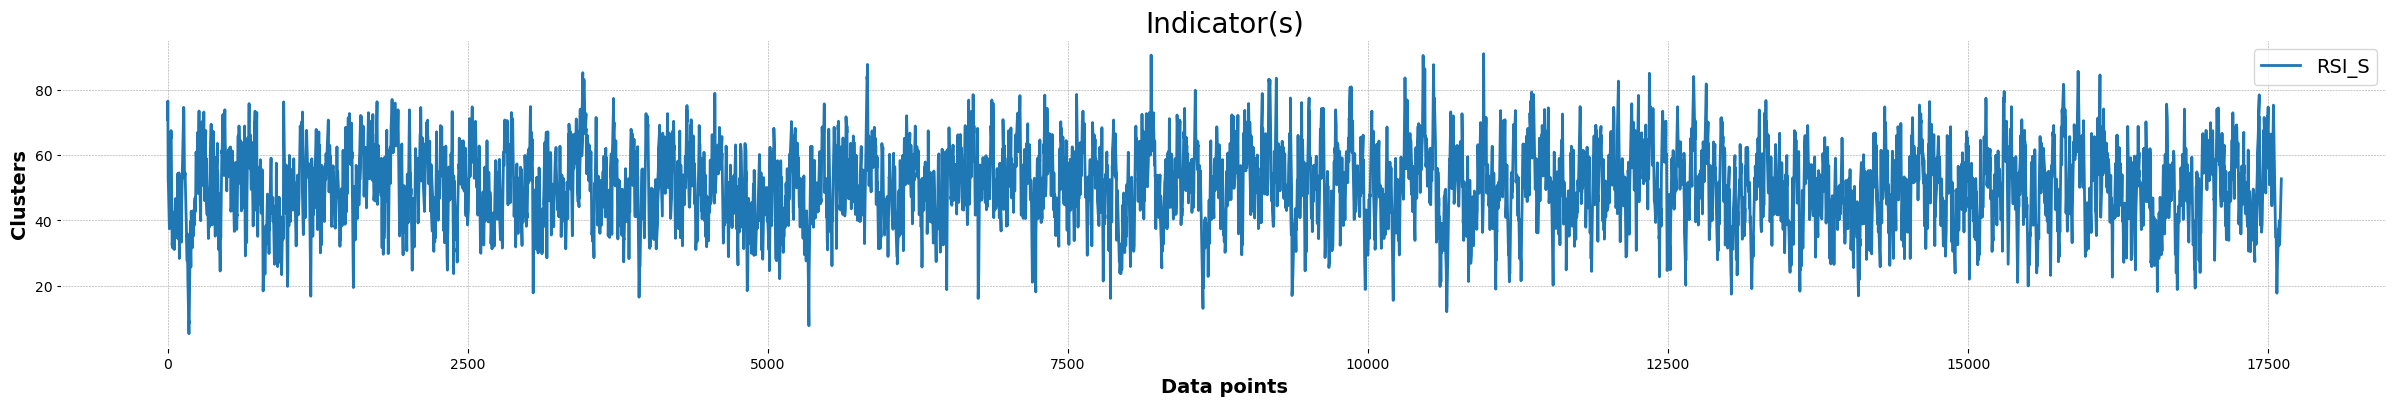

In [784]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((pdta.ema(dataset['RSI_S'], 100) > 60)
                             , 1, 0)

dataset['SIGNAL'] = np.where((FELib.llv(dataset['MACD_S'], 100) > 0)
                             , 1, dataset['SIGNAL'])

# Predict open sell / short signal
dataset['SIGNAL'] = np.where((pdta.ema(dataset['RSI_S'], 100) < 40)
                             , 11, dataset['SIGNAL'])

dataset['SIGNAL'] = np.where((FELib.hhv(dataset['MACD_S'], 100) < 0)
                             , 11, dataset['SIGNAL'])

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['RSI_S'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

## Create signals using rule 'sideway in narrow channel'

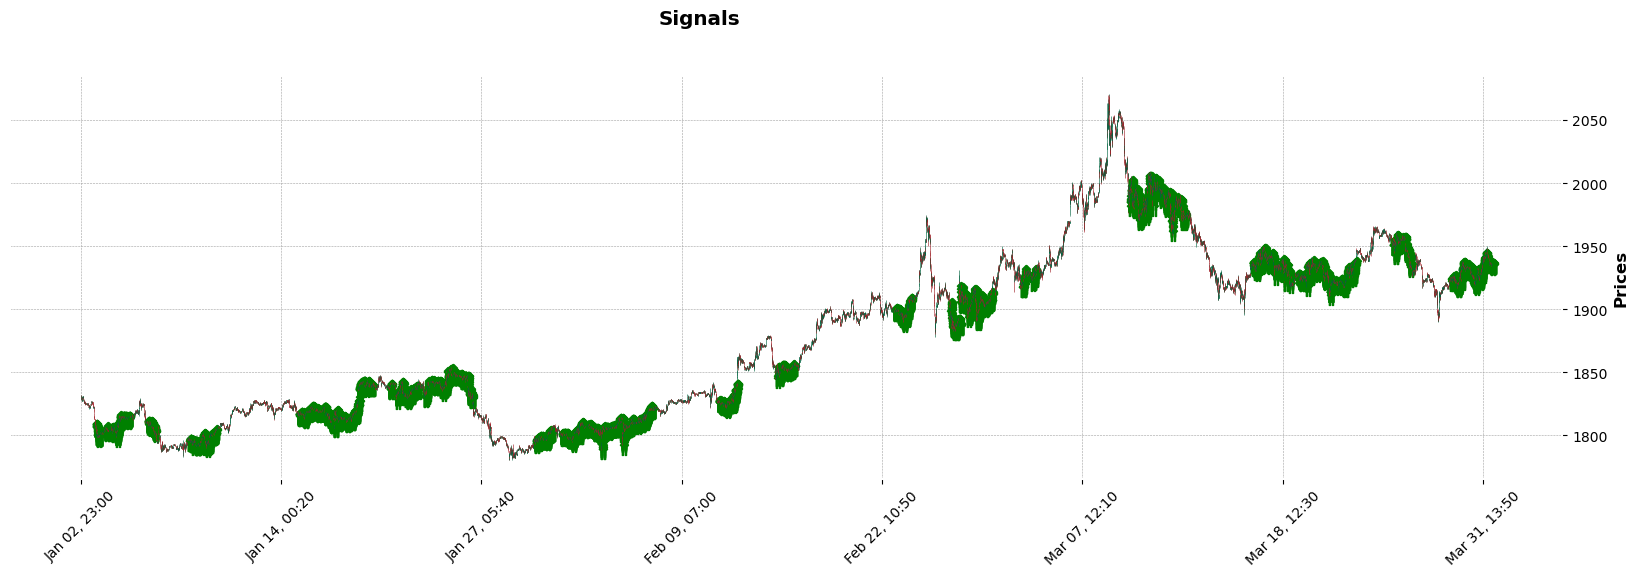

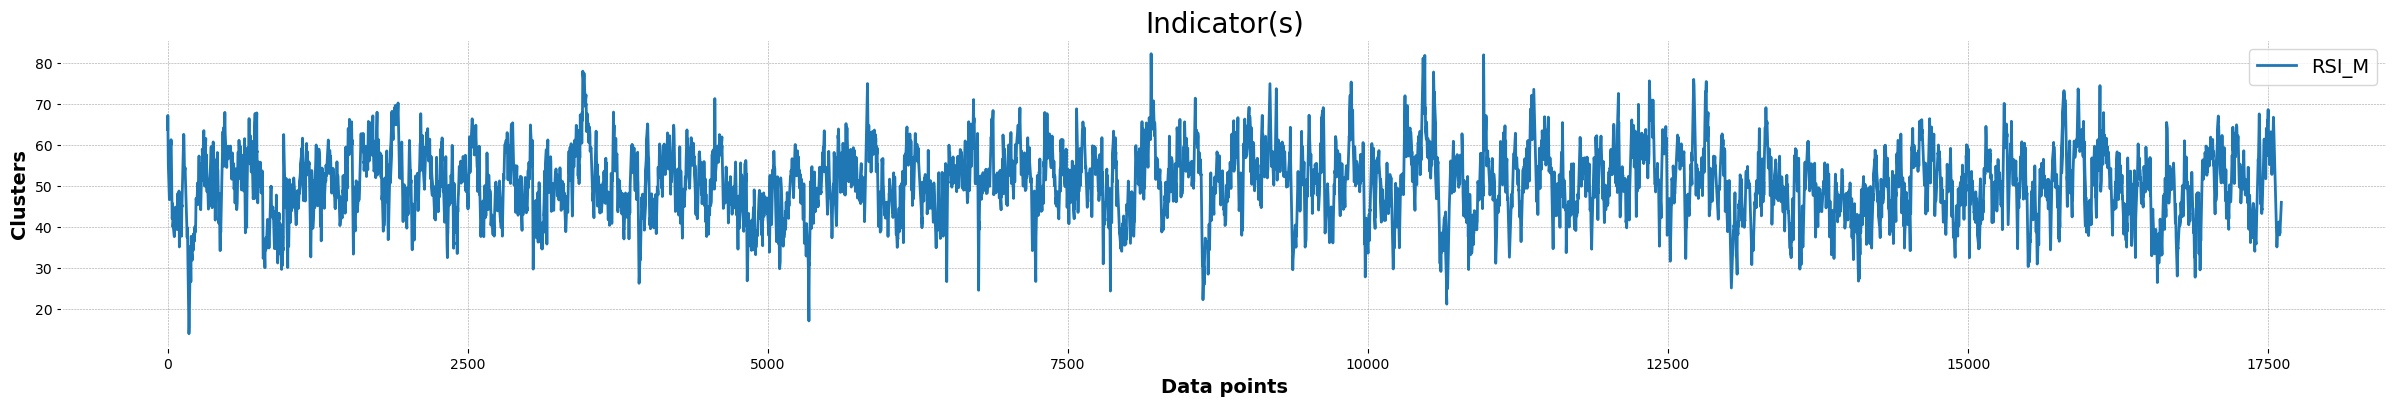

In [785]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((FELib.stdev(dataset['MA2'], 900) < dataset['CLOSE'] * 0.002)
                             | (FELib.stdev(dataset['MA3'], 1500) < dataset['CLOSE'] * 0.002)
                             | ((pdta.ema(dataset['RSI_M'], 900) < 51)
                                & (pdta.ema(dataset['RSI_M'], 900) > 49))
                             , 1, 0)

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['RSI_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

## Create signals using rule 'high swing'

/var/folders/jq/blgybcvn3hn7kmvzb4f9j8z40000gn/T/ipykernel_80420/3999028905.py:76: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  total = series.rolling(period).count()


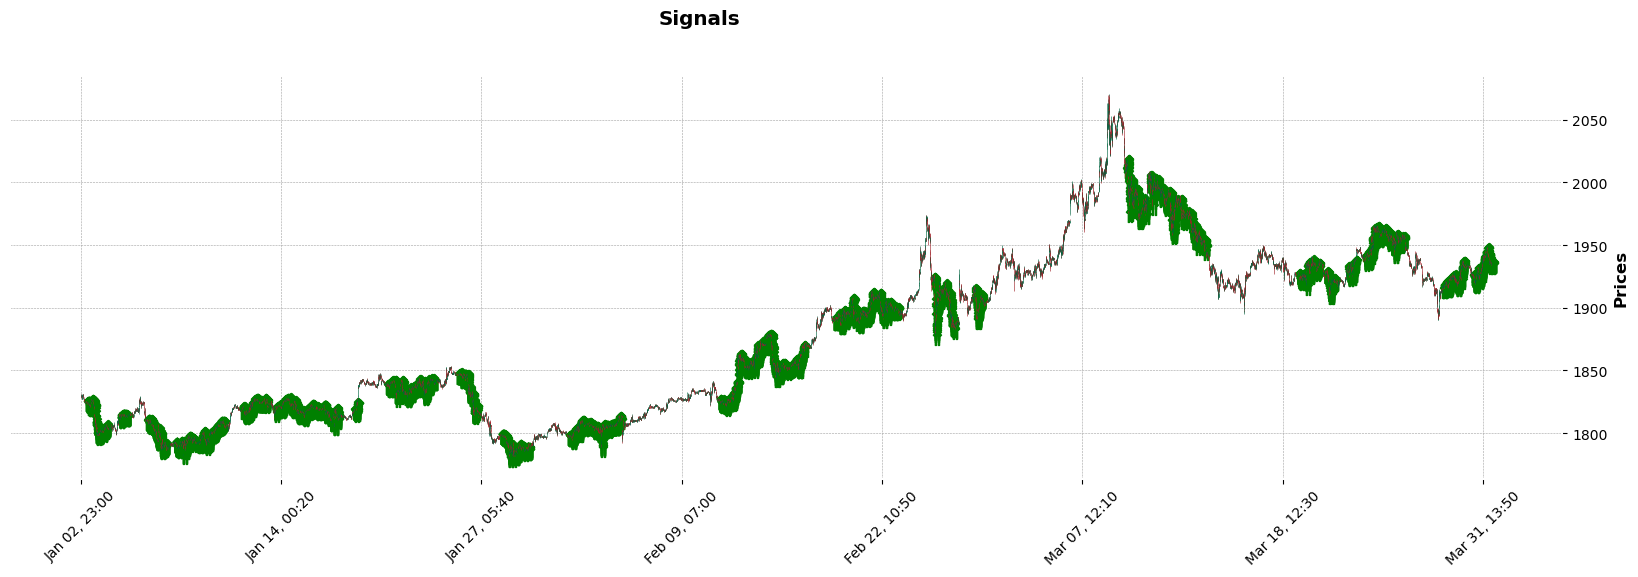

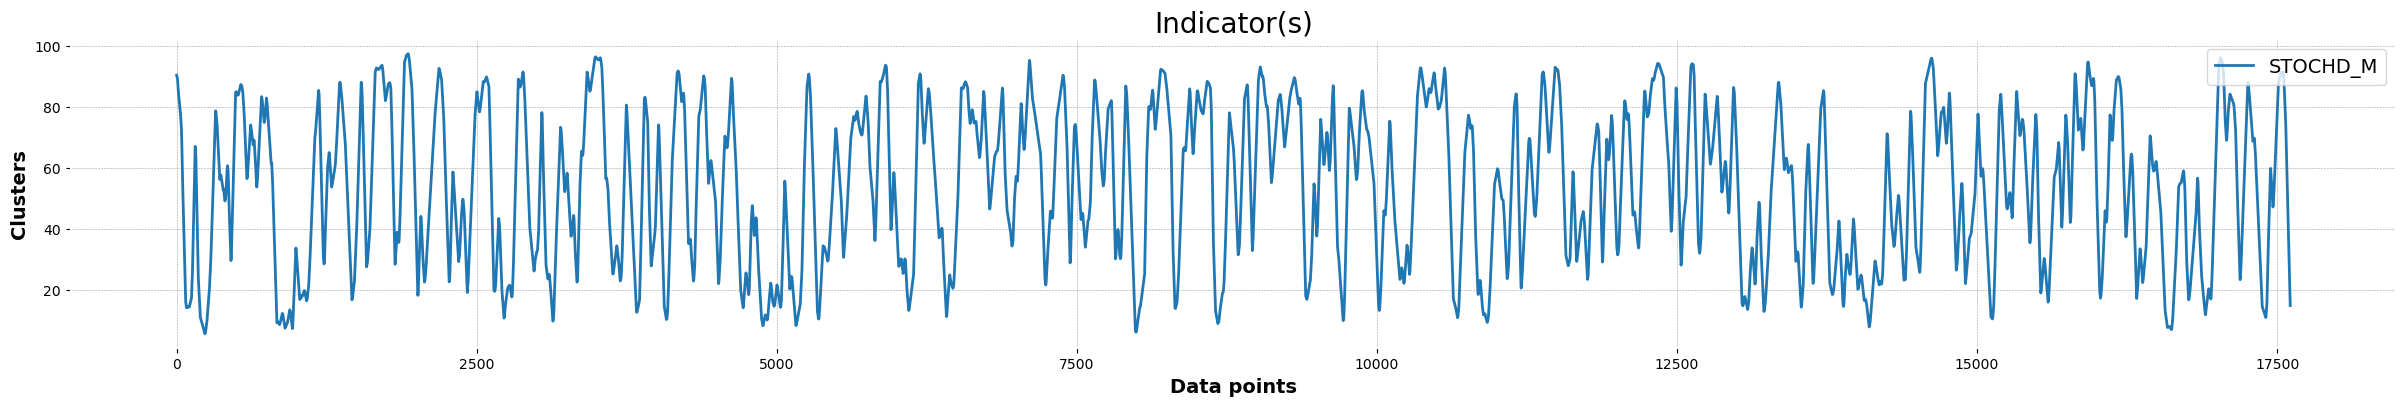

In [786]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((FELib.count_col_cond(dataset['STOCHD_M']
                                                   , "(col > 80)"
                                                   , 300) > 1)
                             & (FELib.count_col_cond(dataset['STOCHD_M']
                                                   , "(col < 20)"
                                                   , 300) > 1)
                             , 1, 0)

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['STOCHD_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

## Create signals using rule 'count green/red bars'

/var/folders/jq/blgybcvn3hn7kmvzb4f9j8z40000gn/T/ipykernel_80420/1046661519.py:2: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  dataset['SIGNAL'] = np.where((pd.Series(np.where(dataset['CLOSE'] > dataset['OPEN']
/var/folders/jq/blgybcvn3hn7kmvzb4f9j8z40000gn/T/ipykernel_80420/1046661519.py:7: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  dataset['SIGNAL'] = np.where((pd.Series(np.where(dataset['CLOSE'] < dataset['OPEN']


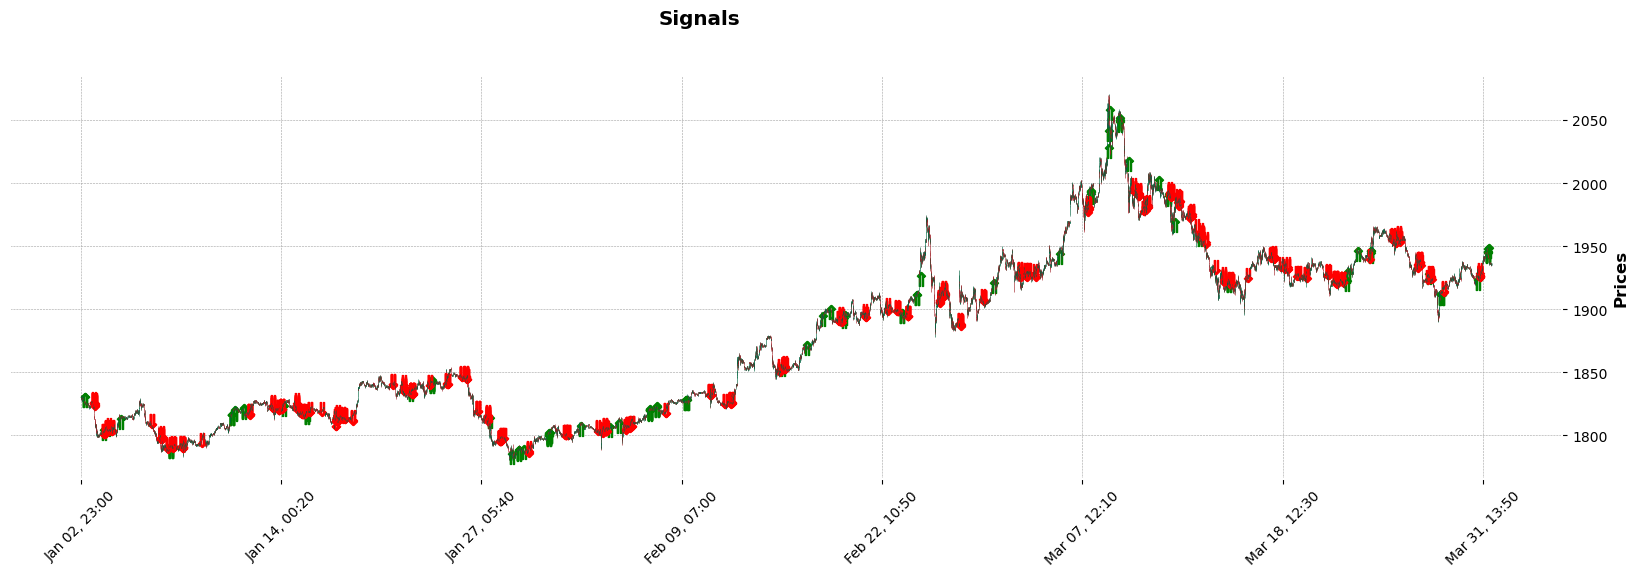

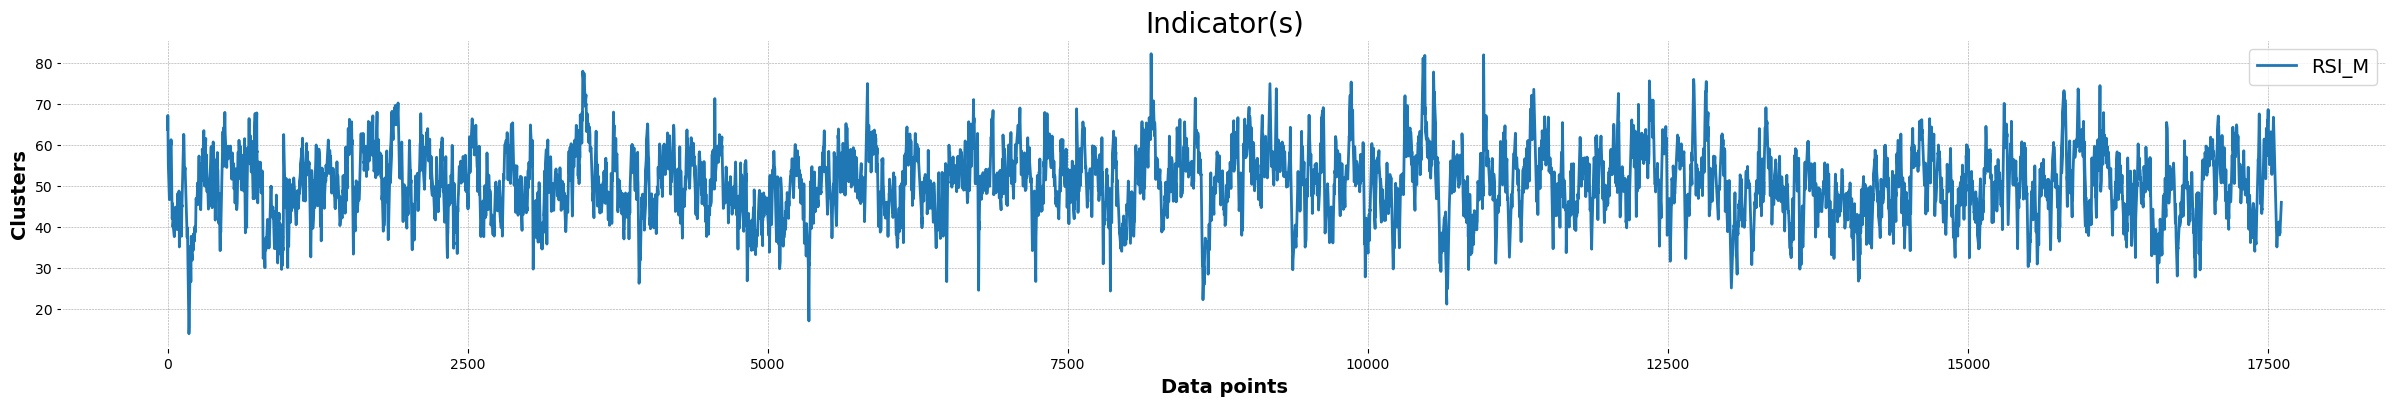

In [787]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((pd.Series(np.where(dataset['CLOSE'] > dataset['OPEN']
                                                , 1, np.nan)).rolling(10).count() > 8)
                             , 1, 0)

# Predict open sell / short signal
dataset['SIGNAL'] = np.where((pd.Series(np.where(dataset['CLOSE'] < dataset['OPEN']
                                                , 1, np.nan)).rolling(10).count() > 5)
                             & (dataset['MACD_SIGNAL_S'] > 0)
                             & (dataset['MACD_S'] < dataset['MACD_SIGNAL_S'])
                             & (dataset['RSI_M'] < 55)
                             & (dataset['MA2'] < pdta.ema(dataset['MA2'], 100))
                             , 11, dataset['SIGNAL'])

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['RSI_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

## Create signals using rule 'false break'

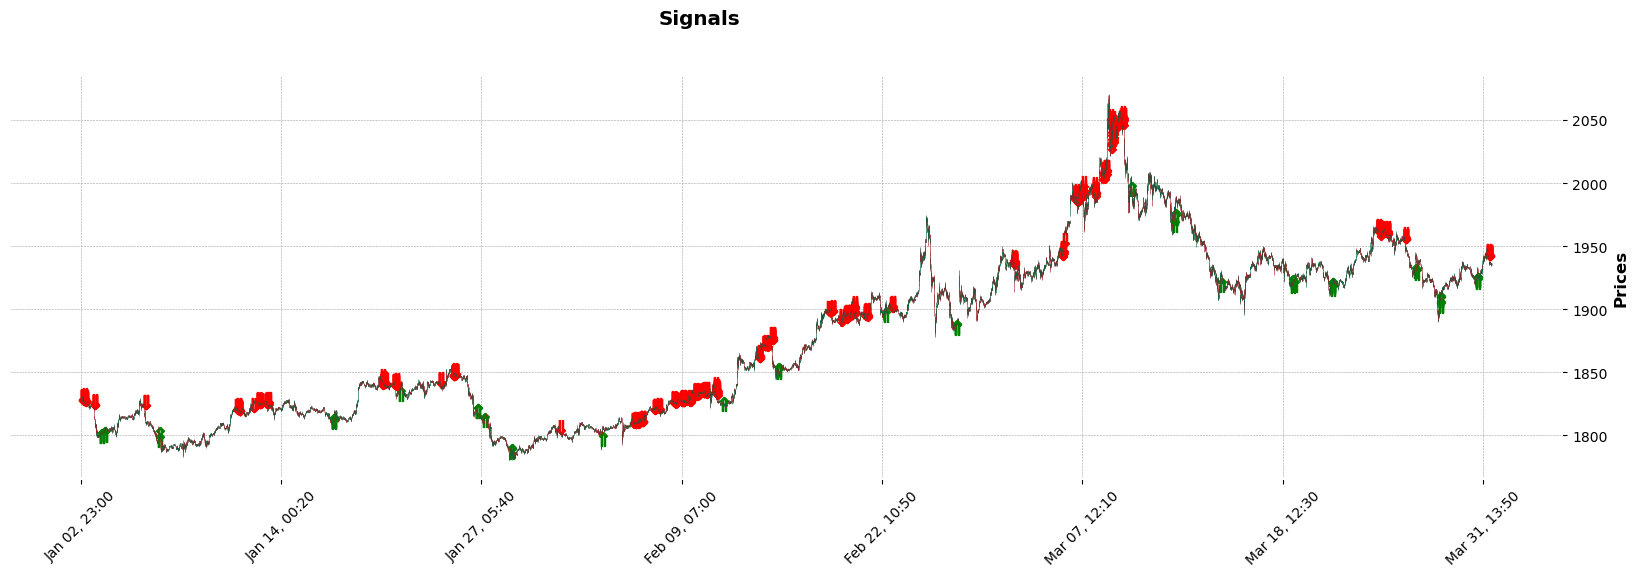

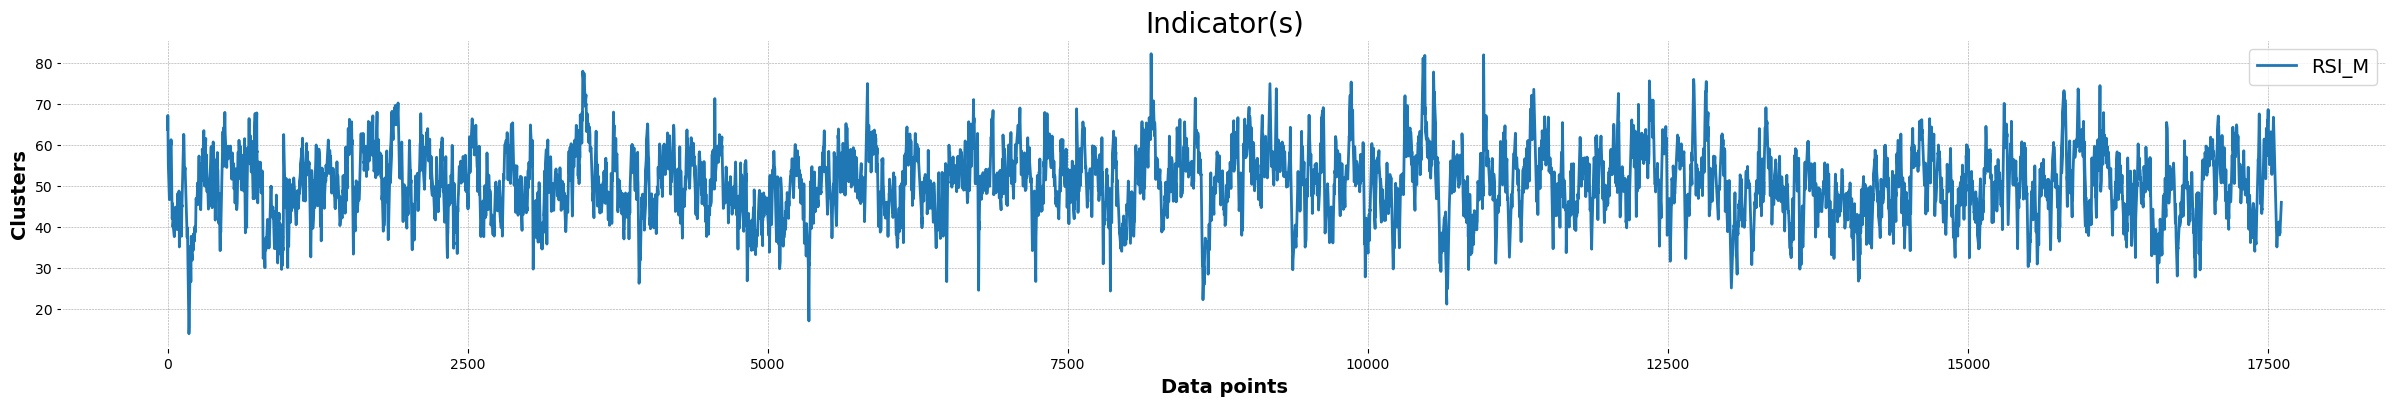

In [788]:
# Predict open buy / long signal
dataset['SIGNAL'] = np.where((dataset['MA2'] < dataset['MA3'])
                             & (dataset['MA3'] < pdta.ema(dataset['MA3'], 10))
                             & (dataset['MACD_SIGNAL_S'] < 0)
                             & (dataset['RSI_S'] > 60)
                             & (dataset['RSI_L'] < 45)
                             & (dataset['CLOSE'] > dataset['MA1'])
                             & (dataset['STOCHK_S'] > 80)
                             , 1, 0)

# Predict open sell / short signal
dataset['SIGNAL'] = np.where((dataset['MA2'] > dataset['MA3'])
                             & (FELib.llv(dataset['MA2'], 300) > FELib.llv(dataset['MA3'], 300))
                             & (dataset['MA3'] > pdta.ema(dataset['MA3'], 10))
                             & (dataset['MA2'] > pdta.ema(dataset['MA2'], 10))
                             & (dataset['CLOSE'] < dataset['MA1'])
                             , 11, dataset['SIGNAL'])

# Remove exceeded open buy and open sell signals
# NOTE: Try to add or remove comment following lines to see the difference between signals visualizing
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 1), 0, dataset['SIGNAL'])
#dataset['SIGNAL'] = np.where((pdta.sma(dataset['SIGNAL'], 10) == 11), 0, dataset['SIGNAL'])

#===============================================================================================

df_sig = data_range(dataset, from_date=date_start, to_date=date_end, window=window_chart)
plot_ohlc_sig(df_ohlc, df_sig, markersize=100, buy_pos=0.999, sell_pos=1.001, c_width=30, c_height=8)

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['RSI_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()